
# PROJECT

Lucrezia Ceresa\
839050\
SDS\
lucrezia.ceresa@edu.unito.it

In [225]:
# conda install -c conda-forge pygam
# !pip install torch torchvision

In [226]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import itertools
import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from pygam import LinearGAM, s
from functools import reduce
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from statsmodels.compat import lzip
from statsmodels.stats.outliers_influence import variance_inflation_factor


### Data cleaning of SALES.

In [227]:
sales = pd.read_csv("sales.csv")
sales

,market_id,date,is_open,sales_amount,
0,XC14,31/12/2022,YES,55727.34,NaN
1,WG25,31/12/2022,YES,12984.10,NaN
2,UX72,31/12/2022,YES,13046.56,NaN
3,EE84,31/12/2022,YES,60916.76,NaN
4,RF54,31/12/2022,YES,12376.42,NaN
...,...,...,...,...,...
523944,ZM74,01/01/2021,YES,21553.84,NaN
523945,WW60,01/01/2021,YES,56371.18,NaN
523946,LU14,01/01/2021,YES,24107.19,NaN
523947,HY57,01/01/2021,YES,12257.38,NaN


In [228]:
sales[' '].isnull().sum() == sales.shape[0] 

True

All the element of the last column are NaN, so we drop it.

In [229]:
col_na_sales = ' '
sales_no_na = sales.drop(col_na_sales, axis = 1)

sales = sales_no_na
sales

,market_id,date,is_open,sales_amount
0,XC14,31/12/2022,YES,55727.34
1,WG25,31/12/2022,YES,12984.10
2,UX72,31/12/2022,YES,13046.56
3,EE84,31/12/2022,YES,60916.76
4,RF54,31/12/2022,YES,12376.42
...,...,...,...,...
523944,ZM74,01/01/2021,YES,21553.84
523945,WW60,01/01/2021,YES,56371.18
523946,LU14,01/01/2021,YES,24107.19
523947,HY57,01/01/2021,YES,12257.38


Now we check if there are any other na values.

In [230]:
sales.isnull().sum()

market_id        1
date             1
is_open          1
sales_amount    15
dtype: int64

In [231]:
sales.loc[(sales['market_id'].isna()) | (sales['date'].isna()) | (sales['is_open'].isna()) | (sales['sales_amount'].isna())]

,market_id,date,is_open,sales_amount
98,OG21,31/12/2022,YES,NaN
174088,UF73,12/04/2022,YES,NaN
223239,BY57,05/02/2022,YES,NaN
477294,NaN,NaN,NaN,NaN
509998,NL22,19/01/2021,YES,NaN
509999,QX97,19/01/2021,YES,NaN
510000,AB90,19/01/2021,YES,NaN
510001,KR60,19/01/2021,YES,NaN
510002,SF72,19/01/2021,YES,NaN
510003,SY36,19/01/2021,YES,NaN


The row indexed by 477294 with all na values, so we can delete it.

In [232]:
print('The number of rows of sales is', sales.shape[0])

na_row_sales = sales[sales['market_id'].isna()].index.tolist()
drop_na_row_sales = sales.drop(na_row_sales, axis=0)

sales = drop_na_row_sales
sales

print('After dropping the row, the number of rows of sales is', sales.shape[0])

The number of rows of sales is 523949
After dropping the row, the number of rows of sales is 523948


In [233]:
sales.isnull().sum()

market_id        0
date             0
is_open          0
sales_amount    14
dtype: int64

We still have 14 values of sales_amount are NaN. Let's replace each of them with the mean of the sales amounts of the same market in the other days.

In [234]:
na_amount_index = sales.loc[sales['sales_amount'].isna()].index.tolist()
sales.loc[na_amount_index]

,market_id,date,is_open,sales_amount
98,OG21,31/12/2022,YES,NaN
174088,UF73,12/04/2022,YES,NaN
223239,BY57,05/02/2022,YES,NaN
509998,NL22,19/01/2021,YES,NaN
509999,QX97,19/01/2021,YES,NaN
510000,AB90,19/01/2021,YES,NaN
510001,KR60,19/01/2021,YES,NaN
510002,SF72,19/01/2021,YES,NaN
510003,SY36,19/01/2021,YES,NaN
510004,FH27,19/01/2021,YES,NaN


All these markets were open, so none amount must be replaced with 0.

Let's check if there are negative values that can be considered NaN values.

In [235]:
sales.loc[(sales['is_open'] == 'YES') & (sales['sales_amount'] < 0)]

,market_id,date,is_open,sales_amount
47528,XC14,16/10/2022,YES,-999999.0
48150,XC14,15/10/2022,YES,-999999.0
48772,XC14,14/10/2022,YES,-999999.0
49394,XC14,13/10/2022,YES,-999999.0
50016,XC14,12/10/2022,YES,-999999.0
50638,XC14,11/10/2022,YES,-999999.0


In [236]:
sales.replace(-999999.0, np.nan, inplace=True)
sales.loc[sales['sales_amount'].isna()]

,market_id,date,is_open,sales_amount
98,OG21,31/12/2022,YES,NaN
47528,XC14,16/10/2022,YES,NaN
48150,XC14,15/10/2022,YES,NaN
48772,XC14,14/10/2022,YES,NaN
49394,XC14,13/10/2022,YES,NaN
50016,XC14,12/10/2022,YES,NaN
50638,XC14,11/10/2022,YES,NaN
174088,UF73,12/04/2022,YES,NaN
223239,BY57,05/02/2022,YES,NaN
509998,NL22,19/01/2021,YES,NaN


In [237]:
na_amount_id = sales.loc[sales['sales_amount'].isna()]['market_id']
na_amount_id_index = na_amount_id.index.tolist()

list_idmarket = np.unique(na_amount_id).tolist()
list_idmarket

['AB90',
 'BY57',
 'CI77',
 'FH27',
 'HJ11',
 'KR60',
 'NL22',
 'OA13',
 'OG21',
 'QX97',
 'SF72',
 'SY36',
 'TX18',
 'UF73',
 'XC14']

In [238]:
# compute the means

open_notna_sales = sales.loc[(sales['is_open'] == 'YES') & (sales['sales_amount'].isna() == False)]

id_means = {}

for id in list_idmarket:
    amounts = open_notna_sales.loc[open_notna_sales['market_id'] == id]['sales_amount']
    mean = amounts.sum() / (len(amounts)) 
    id_means[id] = mean

id_means


{'AB90': 26124.28376859504,
 'BY57': 12628.22232172471,
 'CI77': 12397.399425287356,
 'FH27': 12520.668232662192,
 'HJ11': 12355.999983471074,
 'KR60': 11123.656971235194,
 'NL22': 12017.34991749175,
 'OA13': 12543.885878378378,
 'OG21': 62768.8625279642,
 'QX97': 12467.709522240526,
 'SF72': 12557.66355848435,
 'SY36': 57956.42165289256,
 'TX18': 23315.179071310118,
 'UF73': 12005.331013513514,
 'XC14': 60603.900400000006}

In [239]:
# substitute the means to the NaN amounts

for id in id_means.keys():
    sales['sales_amount'][(sales['market_id'] == id) & sales['sales_amount'].isna()] = id_means[id]

sales.loc[na_amount_id_index]

C:\Users\Lucrezia\AppData\Local\Temp\ipykernel_1968\4000179224.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales['sales_amount'][(sales['market_id'] == id) & sales['sales_amount'].isna()] = id_means[id]
C:\Users\Lucrezia\AppData\Local\Temp\ipykernel_1968\4000179224.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales['sales_amount'][(sales['market_id'] == id) & sales['sales_amount'].isna()] = id_means[id]
C:\Users\Lucrezia\AppData\Local\Temp\ipykernel_1968\4000179224.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https

,market_id,date,is_open,sales_amount
98,OG21,31/12/2022,YES,62768.862528
47528,XC14,16/10/2022,YES,60603.900400
48150,XC14,15/10/2022,YES,60603.900400
48772,XC14,14/10/2022,YES,60603.900400
49394,XC14,13/10/2022,YES,60603.900400
50016,XC14,12/10/2022,YES,60603.900400
50638,XC14,11/10/2022,YES,60603.900400
174088,UF73,12/04/2022,YES,12005.331014
223239,BY57,05/02/2022,YES,12628.222322
509998,NL22,19/01/2021,YES,12017.349917


In [240]:
# check if all na values are now available

sales.loc[na_amount_index]

sales.isnull().sum()

market_id       0
date            0
is_open         0
sales_amount    0
dtype: int64

Now we check if there are other errors in all the columns.

**market_id**: string

In [241]:
# check market_id

no_str_id = len(sales.loc[sales['market_id'].apply(lambda x: isinstance(x, str)) == False])
print(f'the number of market_id that are not strings is {no_str_id}')

the number of market_id that are not strings is 0


**date**: date from 01/01/2021 till 31/12/2022

In [242]:
# check date

for date in sales['date']:
    day = int(date[0:2])
    month = int(date[3:5])
    year = int(date[6:10])
    slash = [date[2], date[5]]

    if (day<1) or (day>31) :
        print('day error')
   
    if (month<1) or (month>12) :
        print('month error')
    
    if (year<2021) or (year>2022) :
        print('year error')
    
    if (slash[0] != '/') or (slash[1] != '/') :
        print('slash error')

In [243]:
sales['date'] = pd.to_datetime(sales['date'], dayfirst=True)
sales['date']

0        2022-12-31
1        2022-12-31
2        2022-12-31
3        2022-12-31
4        2022-12-31
            ...    
523944   2021-01-01
523945   2021-01-01
523946   2021-01-01
523947   2021-01-01
523948   2021-01-01
Name: date, Length: 523948, dtype: datetime64[ns]

**is_open**: string YES or NO.

In [244]:
# check is_open 

error_is_open = len(sales.loc[(sales['is_open'] != 'YES') & (sales['is_open'] != 'NO')])
print(f'The number of errors in is_open is {error_is_open}')

sales.loc[(sales['is_open'] != 'YES') & (sales['is_open'] != 'NO')]

The number of errors in is_open is 1


,market_id,date,is_open,sales_amount
49154,BT51,2022-10-14,YESS,25220.48


In [245]:
sales['is_open'][49154] = 'YES'

sales.loc[49154]

C:\Users\Lucrezia\AppData\Local\Temp\ipykernel_1968\2241980463.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales['is_open'][49154] = 'YES'


market_id                      BT51
date            2022-10-14 00:00:00
is_open                         YES
sales_amount               25220.48
Name: 49154, dtype: object

**sales_amounts**: floats $\ge$ 0, float = 0 if is_open = NO.

In [246]:
# check sales_amount

error_amount = len(sales.loc[(sales['sales_amount'].apply(lambda x: isinstance(x, float)) == False) | 
                                (sales['sales_amount'] < 0)])
print(f'the number of elements in sales_amount that are negative and not float is {error_amount}')

error_closed = len(sales.loc[(sales['is_open'] == 'NO') & (sales['sales_amount'] != 0)])
print(f'the number of elements in sales_amount that are positive even if the market was closed is {error_closed}')

the number of elements in sales_amount that are negative and not float is 0
the number of elements in sales_amount that are positive even if the market was closed is 1


In [247]:
sales.loc[(sales['is_open'] == 'NO') & (sales['sales_amount'] != 0)]

,market_id,date,is_open,sales_amount
753,EE84,2022-12-30,NO,9999999.0


In [248]:
index_no_zeroamount = sales.loc[(sales['is_open'] == 'NO') & (sales['sales_amount'] != 0)].index.tolist()
sales['sales_amount'][index_no_zeroamount] = 0

sales.loc[753]

C:\Users\Lucrezia\AppData\Local\Temp\ipykernel_1968\284395850.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales['sales_amount'][index_no_zeroamount] = 0


market_id                      EE84
date            2022-12-30 00:00:00
is_open                          NO
sales_amount                    0.0
Name: 753, dtype: object

The columns are now corrected. 

Let's check if there are duplicated rows.

In [249]:
duplicated_rows_sales = len(sales.duplicated()[sales.duplicated() == True])
print(f'the number of duplicated rows of sales is {duplicated_rows_sales}')

the number of duplicated rows of sales is 0


### Data cleaning of MARKET.

In [250]:
market = pd.read_csv("market.csv")
market

,id,country,Unnamed: 2,market_type,square_feet,avg_customers,competitor_distance,has_promotions
0,XC14,SPAIN,NaN,HYPER,11135,773.0,515,YES
1,WG25,FRANCE,NaN,MINI,1402,252.0,522,YES
2,UX72,FRANCE,NaN,MINI,1452,265.0,15939,YES
3,EE84,SPAIN,NaN,HYPER,15259,874.0,754,YES
4,RF54,FRANCE,NaN,MINI,2497,191.0,34007,YES
...,...,...,...,...,...,...,...,...
745,ZM74,ITALY,NaN,SUPER,5778,356.0,4424,YES
746,WW60,FRANCE,NaN,HYPER,10923,907.0,41359,YES
747,LU14,ITALY,NaN,SUPER,5742,397.0,2841,YES
748,HY57,ITALY,NaN,MINI,2495,228.0,3848,YES


In [251]:
market['Unnamed: 2'].isnull().sum() == market.shape[0]

True

The column Unnamed: 2 contains all na values, so we drop it.

In [252]:
market_without_nacol = market.drop('Unnamed: 2', axis = 1)

market = market_without_nacol
market

,id,country,market_type,square_feet,avg_customers,competitor_distance,has_promotions
0,XC14,SPAIN,HYPER,11135,773.0,515,YES
1,WG25,FRANCE,MINI,1402,252.0,522,YES
2,UX72,FRANCE,MINI,1452,265.0,15939,YES
3,EE84,SPAIN,HYPER,15259,874.0,754,YES
4,RF54,FRANCE,MINI,2497,191.0,34007,YES
...,...,...,...,...,...,...,...
745,ZM74,ITALY,SUPER,5778,356.0,4424,YES
746,WW60,FRANCE,HYPER,10923,907.0,41359,YES
747,LU14,ITALY,SUPER,5742,397.0,2841,YES
748,HY57,ITALY,MINI,2495,228.0,3848,YES


Now let's see if there are NaN values.

In [253]:
market.isnull().sum()

id                     0
country                0
market_type            2
square_feet            0
avg_customers          1
competitor_distance    0
has_promotions         0
dtype: int64

2 market_types and 1 avg_customers are missing.

In [254]:
market.loc[(market['market_type'].isna()) | (market['avg_customers'].isna())]

,id,country,market_type,square_feet,avg_customers,competitor_distance,has_promotions
90,RU30,SPAIN,NaN,14305,637.0,1701,YES
225,KB10,ITALY,NaN,1520,150.0,479,YES
626,OD40,ITALY,HYPER,14157,NaN,3519,YES


We want to replace NaN values in market_type column with respect to the size of square_feet. So first af all we check errors in square_feet column, then we'll compute the means and see which one is the nearest. 

**square_feet**: positive integers.

In [255]:
notint_sqf = len(market.loc[market['square_feet'].apply(lambda x: isinstance(x, int)) == False])
print(f'the number of not integer square_feet values is {notint_sqf}')

neg_sqf = len(market.loc[market['square_feet'] < 0])
print(f'the number of negative values in the square_feet column is {neg_sqf}')

the number of not integer square_feet values is 0
the number of negative values in the square_feet column is 0


In [256]:
# SPAIN square_feet means

hyper_spain = market.loc[(market['country'] == 'SPAIN') & (market['market_type'] == 'HYPER')]['square_feet'].mean()
super_spain = market.loc[(market['country'] == 'SPAIN') & (market['market_type'] == 'SUPER')]['square_feet'].mean()
mini_spain = market.loc[(market['country'] == 'SPAIN') & (market['market_type'] == 'MINI')]['square_feet'].mean()

print(f'hyper in spain = {hyper_spain}, \nsuper in spain = {super_spain}, \nmini in spain = {mini_spain}')

hyper in spain = 12063.774193548386, 
super in spain = 6079.606060606061, 
mini in spain = 1978.367088607595


The market RU30 square_feet value is 14305. The nerest mean is 12064, so it is an hypermarket.

In [257]:
market['market_type'][90] = 'HYPER'

C:\Users\Lucrezia\AppData\Local\Temp\ipykernel_1968\597351061.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  market['market_type'][90] = 'HYPER'


In [258]:
market.loc[(market['market_type'].isna()) | (market['avg_customers'].isna())]

,id,country,market_type,square_feet,avg_customers,competitor_distance,has_promotions
225,KB10,ITALY,NaN,1520,150.0,479,YES
626,OD40,ITALY,HYPER,14157,NaN,3519,YES


In [259]:
# ITALY square_feet means

hyper_italy = market.loc[(market['country'] == 'ITALY') & (market['market_type'] == 'HYPER')]['square_feet'].mean()
super_italy = market.loc[(market['country'] == 'ITALY') & (market['market_type'] == 'SUPER')]['square_feet'].mean()
mini_italy = market.loc[(market['country'] == 'ITALY') & (market['market_type'] == 'MINI')]['square_feet'].mean()

print(f'hyper in italy = {hyper_italy}, \nsuper in italy = {super_italy}, \nmini in italy = {mini_italy}')

hyper in italy = 12052.172413793103, 
super in italy = 6067.6551724137935, 
mini in italy = 2054.526785714286


The market KB10 square_feet value is 1520. The nerest mean is 2055, so it is a minimarket.

In [260]:
market['market_type'][225] = 'MINI'

C:\Users\Lucrezia\AppData\Local\Temp\ipykernel_1968\1679627299.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  market['market_type'][225] = 'MINI'


In [261]:
market.loc[(market['market_type'].isna()) | (market['avg_customers'].isna())]

,id,country,market_type,square_feet,avg_customers,competitor_distance,has_promotions
626,OD40,ITALY,HYPER,14157,NaN,3519,YES


Now let's transform the avg_customers NaN value. We substitute it with the mean of avg_customers of hypermakets located in Italy. But first we must be sure that the column avg_customers has no errors.

**avg_customers**: positive integers.

In [262]:
market.loc[market['avg_customers'] < 0]

,id,country,market_type,square_feet,avg_customers,competitor_distance,has_promotions
69,IP89,SPAIN,HYPER,15560,-9999.0,6281,YES


In [263]:
market.replace(market['avg_customers'][69], np.nan, inplace=True)
market.loc[market['avg_customers'].isna()]

,id,country,market_type,square_feet,avg_customers,competitor_distance,has_promotions
69,IP89,SPAIN,HYPER,15560,NaN,6281,YES
626,OD40,ITALY,HYPER,14157,NaN,3519,YES


In [264]:
max(market['avg_customers']) 

915.0

In [265]:
# check avg_customers

noint_avg = len(market.loc[market['avg_customers'].apply(lambda x: isinstance(x,int)) == False])
print(f'the number of market avg customers that are not integers is {noint_avg}')

the number of market avg customers that are not integers is 750


In [266]:
market['avg_customers']

0      773.0
1      252.0
2      265.0
3      874.0
4      191.0
       ...  
745    356.0
746    907.0
747    397.0
748    228.0
749    516.0
Name: avg_customers, Length: 750, dtype: float64

They are float, but the decimal part is 0, so we simply must exchange the type.

In [267]:
market['avg_customers'].loc[market['avg_customers'].isna()==False] = market.loc[market['avg_customers'].isna()==False]['avg_customers'].astype(int)

int_avg = len(market.loc[market['avg_customers'].apply(lambda x: isinstance(x,int)) == False])
print(f'the number of market avg customers that are not integers is {int_avg}')

the number of market avg customers that are not integers is 750


C:\Users\Lucrezia\AppData\Local\Temp\ipykernel_1968\539749532.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  market['avg_customers'].loc[market['avg_customers'].isna()==False] = market.loc[market['avg_customers'].isna()==False]['avg_customers'].astype(int)


There are no other errors.

In [268]:
# SPAIN HYPER avg_customers mean

mean_spain_hyper = market.loc[(market['country'] == 'SPAIN') & (market['market_type'] == 'HYPER')]['avg_customers'].mean()

print(f'The mean of avg_customers of hypermarkets in Spain is {mean_spain_hyper}')

The mean of avg_customers of hypermarkets in Spain is 763.483870967742


In [269]:
market['avg_customers'][69] = 763

C:\Users\Lucrezia\AppData\Local\Temp\ipykernel_1968\1970641263.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  market['avg_customers'][69] = 763


In [270]:
market.loc[market['avg_customers'].isna()]

,id,country,market_type,square_feet,avg_customers,competitor_distance,has_promotions
626,OD40,ITALY,HYPER,14157,NaN,3519,YES


In [271]:
# ITALY HYPER avg_customers mean

mean_italy_hyper = market.loc[(market['country'] == 'ITALY') & (market['market_type'] == 'HYPER')]['avg_customers'].mean()

print(f'The mean of avg_customers of hypermarkets in Italy is {mean_italy_hyper}')

The mean of avg_customers of hypermarkets in Italy is 733.7857142857143


In [272]:
market['avg_customers'][626] = 734

C:\Users\Lucrezia\AppData\Local\Temp\ipykernel_1968\2463313333.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  market['avg_customers'][626] = 734


In [273]:
market.isnull().sum()

id                     0
country                0
market_type            0
square_feet            0
avg_customers          0
competitor_distance    0
has_promotions         0
dtype: int64

There are no more na values. \
Now let's check if there are some other errors in the columns.

**id_market**: unique strings. 

In [274]:
# check if market_id contains strings

str_id = len(market.loc[market['id'].apply(lambda x: isinstance(x, str)) == False])
print(f'the number of values of market_id that are not strings is {str_id}')

# check if market id are unique

unique_id = len(market[market['id'].duplicated() == True])
print(f'the number of duplicated id is {unique_id}')

the number of values of market_id that are not strings is 0
the number of duplicated id is 0


**country**: strings ITALY, SPAIN or FRANCE.

In [275]:
# check country names

names_mistake = len(market.loc[(market['country'] != 'ITALY') & (market['country'] != 'SPAIN') & (market['country'] != 'FRANCE')])
print(f'the number of grammatical mistakes in country is {names_mistake} ')

the number of grammatical mistakes in country is 0 


**market_type**: strings MINI, SUPER or HYPER. 

In [276]:
# check market_type 

error_type = len(market.loc[(market['market_type'] != 'MINI') & (market['market_type'] != 'SUPER') & (market['market_type'] != 'HYPER')])
print(f'the number of market type that are not strings is {error_type}')

the number of market type that are not strings is 0


**competitor_distance**: positive integers.

In [277]:
# check competitor_distance

error_dist = len(market.loc[(market['competitor_distance'] < 0) | 
                            (market['competitor_distance'].apply(lambda x: isinstance(x,int)) == False)])
print(f'the number of competitor_distance that are not positive integers is {error_dist}')

the number of competitor_distance that are not positive integers is 0


**has_promotions**: strings YES or NO.

In [278]:
# check has_promotions

yes_no_prom = len(market.loc[(market['has_promotions'] != 'YES') & (market['has_promotions'] != 'NO')])
print(f'the number of has_promotions that are not YES or NO is {yes_no_prom}')


the number of has_promotions that are not YES or NO is 0


The last check is for duplicated rows.

In [279]:
duplicated_rows_market = len(market['id'].duplicated()[market.duplicated() == True])
print(f'the number of duplicated rows of market is {duplicated_rows_market}')

the number of duplicated rows of market is 0


### Generate the dataset 
Since “sales.csv” contains temporal information. To capture the main relationships between target and predictors we collapse the temporal dimension.

We generate a new dataset, called "collapsed_time_sales": in the first column there are market id's without repetitions and in the second column we insert the dayly average amounts, computed with datas of the years 2021 and 2022.

In [280]:
collapsed_time_sales = sales[['market_id', 'sales_amount']].groupby('market_id', as_index=False).mean()
collapsed_time_sales

,market_id,sales_amount
0,AA39,10433.131548
1,AA82,21804.155256
2,AB90,21686.734197
3,AC71,9728.267912
4,AD13,10219.610630
...,...,...
745,ZX46,10435.278082
746,ZX76,10154.048388
747,ZY62,21847.301630
748,ZZ11,10268.111154


Now that we have a new dataset without the dates, we merge it with “market.csv”. We call this new dataset “merged_df”.

In [281]:
collapsed_time_sales.columns = ['id', 'sales_amount']

In [282]:
merged_df = pd.merge(market, collapsed_time_sales, on='id', how='inner')
merged_df.head(20)

,id,country,market_type,square_feet,avg_customers,competitor_distance,has_promotions,sales_amount
0,XC14,SPAIN,HYPER,11135,773.0,515,YES,50309.539236
1,WG25,FRANCE,MINI,1402,252.0,522,YES,10418.686479
2,UX72,FRANCE,MINI,1452,265.0,15939,YES,10201.225137
3,EE84,SPAIN,HYPER,15259,874.0,754,YES,52161.938041
4,RF54,FRANCE,MINI,2497,191.0,34007,YES,9983.017178
5,ZU61,FRANCE,MINI,1507,162.0,247,YES,10272.053370
6,MY79,FRANCE,MINI,1582,217.0,20274,YES,10268.863699
7,XT76,FRANCE,MINI,2245,187.0,7546,YES,10374.786041
8,RC17,SPAIN,MINI,1641,262.0,1543,YES,9923.909890
9,AL66,FRANCE,MINI,1723,217.0,3215,YES,10397.098589


### Explanation

Let's compute the means of all numeric columns divided by market_type and country and see what are the values.

In [283]:
mini = merged_df.loc[merged_df['market_type']=='MINI']
super = merged_df.loc[merged_df['market_type']=='SUPER']
hyper = merged_df.loc[merged_df['market_type']=='HYPER']

In [284]:
mini_ita = merged_df.loc[(merged_df['market_type']=='MINI') & (merged_df['country']=='ITALY')]
mini_spa = merged_df.loc[(merged_df['market_type']=='MINI') & (merged_df['country']=='SPAIN')]
mini_fra = merged_df.loc[(merged_df['market_type']=='MINI') & (merged_df['country']=='FRANCE')]

super_ita = merged_df.loc[(merged_df['market_type']=='SUPER') & (merged_df['country']=='ITALY')]
super_spa = merged_df.loc[(merged_df['market_type']=='SUPER') & (merged_df['country']=='SPAIN')]
super_fra = merged_df.loc[(merged_df['market_type']=='SUPER') & (merged_df['country']=='FRANCE')]

hyper_ita = merged_df.loc[(merged_df['market_type']=='HYPER') & (merged_df['country']=='ITALY')]
hyper_spa = merged_df.loc[(merged_df['market_type']=='HYPER') & (merged_df['country']=='SPAIN')]
hyper_fra = merged_df.loc[(merged_df['market_type']=='HYPER') & (merged_df['country']=='FRANCE')]

In [285]:
means_variables = []

numeric_columns = ['square_feet', 'avg_customers', 'competitor_distance','sales_amount']

means_variables.append(mini_ita[numeric_columns].mean().tolist())
means_variables.append(mini_spa[numeric_columns].mean().tolist())
means_variables.append(mini_fra[numeric_columns].mean().tolist())

means_variables.append(super_ita[numeric_columns].mean().tolist())
means_variables.append(super_spa[numeric_columns].mean().tolist())
means_variables.append(super_fra[numeric_columns].mean().tolist())

means_variables.append(hyper_ita[numeric_columns].mean().tolist())
means_variables.append(hyper_spa[numeric_columns].mean().tolist())
means_variables.append(hyper_fra[numeric_columns].mean().tolist())


In [286]:
names = ['mini_ita', 'mini_spa', 'mini_fra', 'super_ita', 'super_spa', 'super_fra', 'hyper_ita', 'hyper_spa', 'hyper_fra']
means_df = pd.DataFrame(means_variables, columns=['square_feet', 'avg_customers', 'competitor_distance', 'sales_amount'])
means_df[''] = names
means_df

,square_feet,avg_customers,competitor_distance,sales_amount,
0,2049.796460,208.646018,4401.699115,9474.295978,mini_ita
1,1978.367089,214.329114,4890.835443,9934.077985,mini_spa
2,1998.402778,210.527778,5527.509259,10392.152014,mini_fra
3,6067.655172,401.293103,5502.655172,19580.010181,super_ita
4,6079.606061,405.333333,6891.606061,20613.564912,super_spa
5,6035.285714,401.396825,7183.277778,21540.809441,super_fra
6,12052.172414,733.793103,4191.827586,47184.741992,hyper_ita
7,12133.812500,763.468750,2451.750000,49940.181785,hyper_spa
8,12153.225806,688.258065,5067.612903,51925.824643,hyper_fra


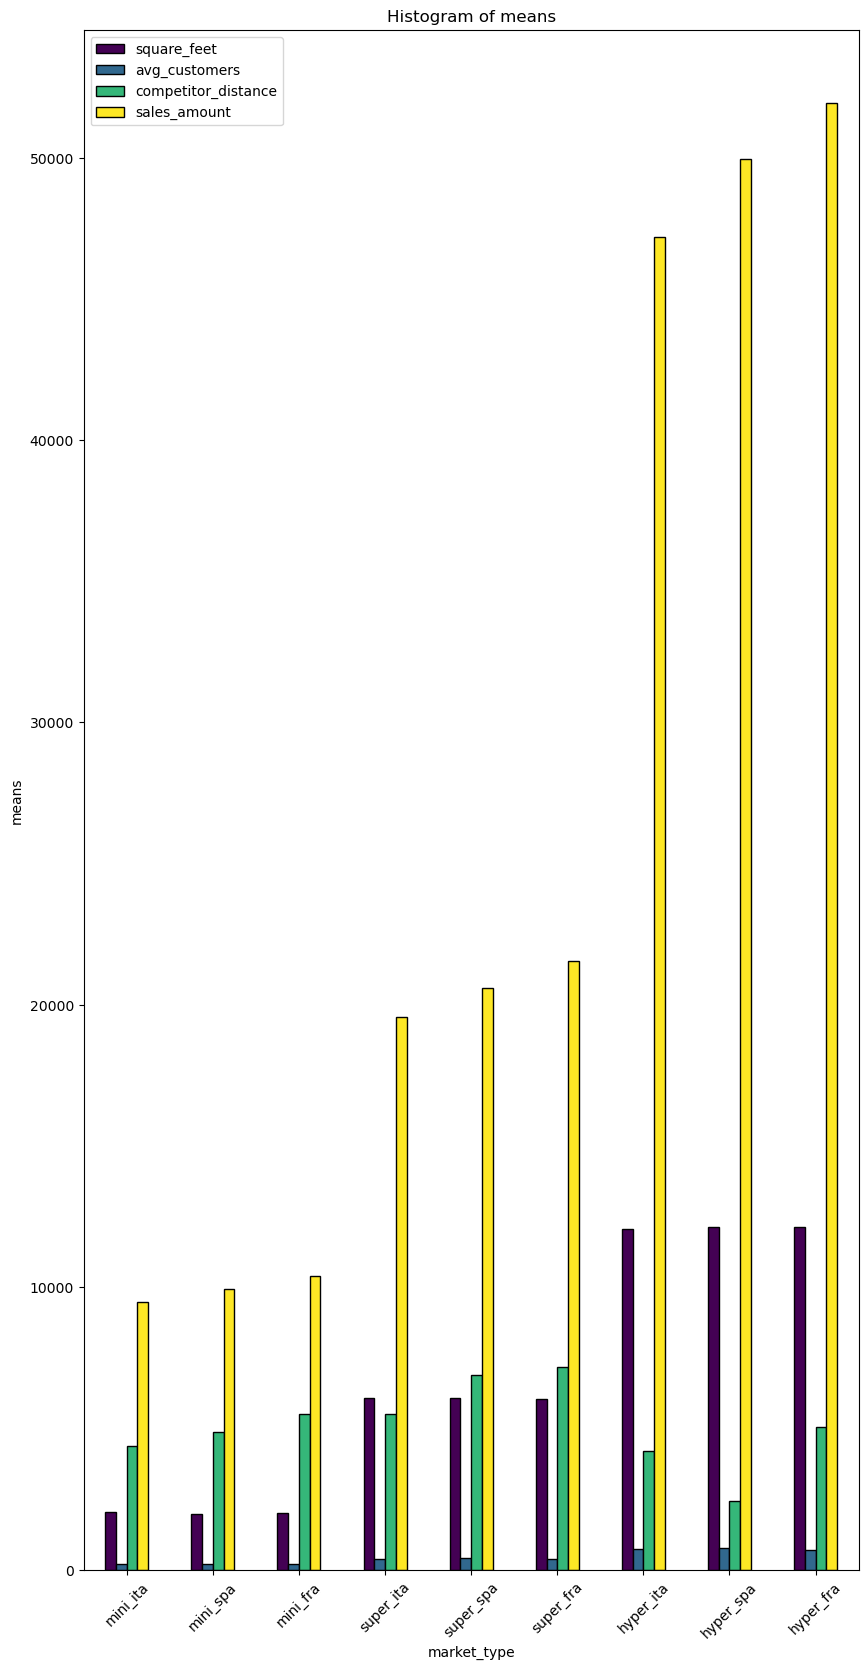

In [287]:
means_df.plot(kind='bar', legend=True, colormap='viridis', edgecolor='black', figsize=(10,20))

plt.xlabel('market_type')
plt.ylabel('means')
plt.title('Histogram of means')
plt.xticks(ticks=range(9), labels=means_df[''].tolist(), rotation=45)
plt.show()

We notice that the France sales_amount averages are always higher than the other. It can be explained by the fact that also the competitor distance and the square feet averages are the highest in France. 

In [288]:
market.loc[market['has_promotions']=='NO']

,id,country,market_type,square_feet,avg_customers,competitor_distance,has_promotions
46,UM31,FRANCE,MINI,1982,272.0,338,NO
54,BJ48,SPAIN,MINI,2464,160.0,752,NO
94,LP41,FRANCE,MINI,2157,164.0,2089,NO
415,WQ42,SPAIN,MINI,2126,257.0,3264,NO


All markets has promotions except four of them. This means that this predictor will not have much weight in predicting the target.

### Outliers

In [289]:
numeric_columns = ['square_feet', 'avg_customers', 'competitor_distance', 'sales_amount']

In [290]:
mini = merged_df.loc[merged_df['market_type']=='MINI'][numeric_columns]
super = merged_df.loc[merged_df['market_type']=='SUPER'][numeric_columns]
hyper = merged_df.loc[merged_df['market_type']=='HYPER'][numeric_columns]

Outliers of minimarkets.

MINIMARKET OUTLIERS:
The column square_feet has 0.0%
The column avg_customers has 0.0%
The column competitor_distance has 15.2%
The column sales_amount has 2.21%


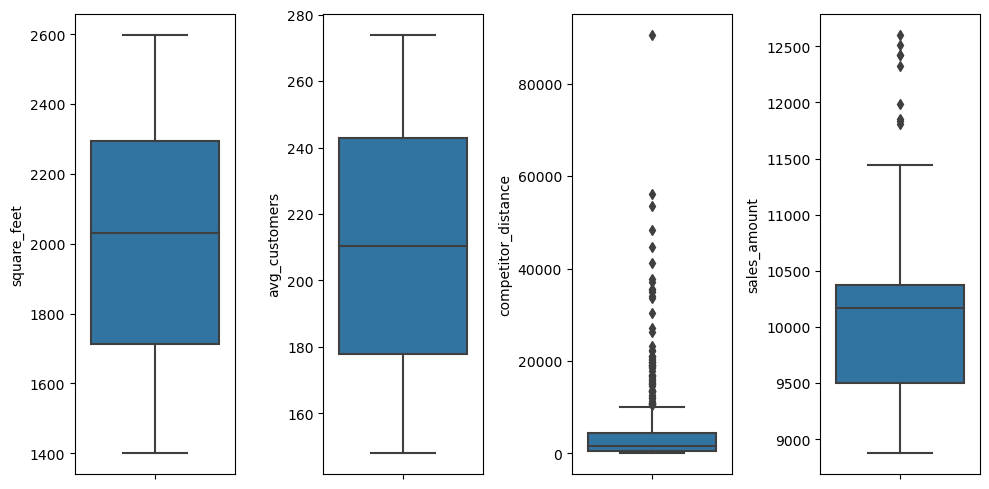

In [291]:
# boxplots

fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(10,5))
index = 0
ax = ax.flatten()
for k, v in mini.items():
    sns.boxplot(y=k, data=mini, ax=ax[index])
    index+=1
plt.tight_layout()

# percentages

print('MINIMARKET OUTLIERS:')
for k, v in mini.items():
    q1 = v.quantile(0.25)
    q3 = v.quantile(0.75)
    iqr = q3-q1
    outliers_mini = v[(v <= q1 - 1.5*iqr) | (v >= q3 + 1.5*iqr)]
    print(f"The column {k} has {round(len(outliers_mini)/len(v) * 100, 2)}%")

Outliers of supermarkets.

SUPERMARKET OUTLIERS:
The column square_feet has 0.0%
The column avg_customers has 0.0%
The column competitor_distance has 2.4%
The column sales_amount has 0.4%


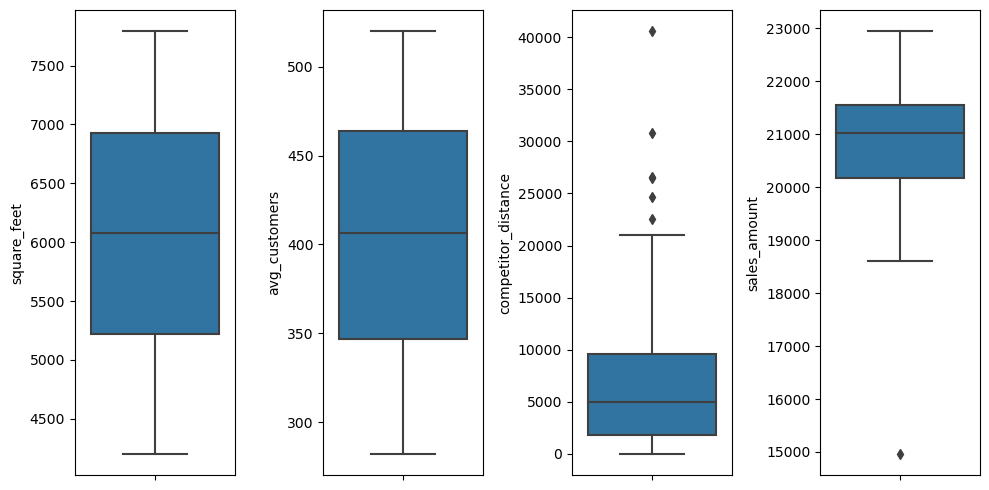

In [292]:
# boxplots

fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(10,5))
index = 0
ax = ax.flatten()

for k, v in super.items():
    sns.boxplot(y=k, data=super, ax=ax[index])
    index+=1
plt.tight_layout()

# percentages

print('SUPERMARKET OUTLIERS:')
for k, v in super.items():
    q1 = v.quantile(0.25)
    q3 = v.quantile(0.75)
    iqr = q3-q1
    outliers_super = v[(v <= q1 - 1.5*iqr) | (v >= q3 + 1.5*iqr)]
    print(f"The column {k} has {round(len(outliers_super)/len(v) * 100, 2)}%")

Outliers of hypermarkets.

HYPERMARKET OUTLIERS:
The column square_feet has 0.0%
The column avg_customers has 0.0%
The column competitor_distance has 9.78%
The column sales_amount has 1.09%


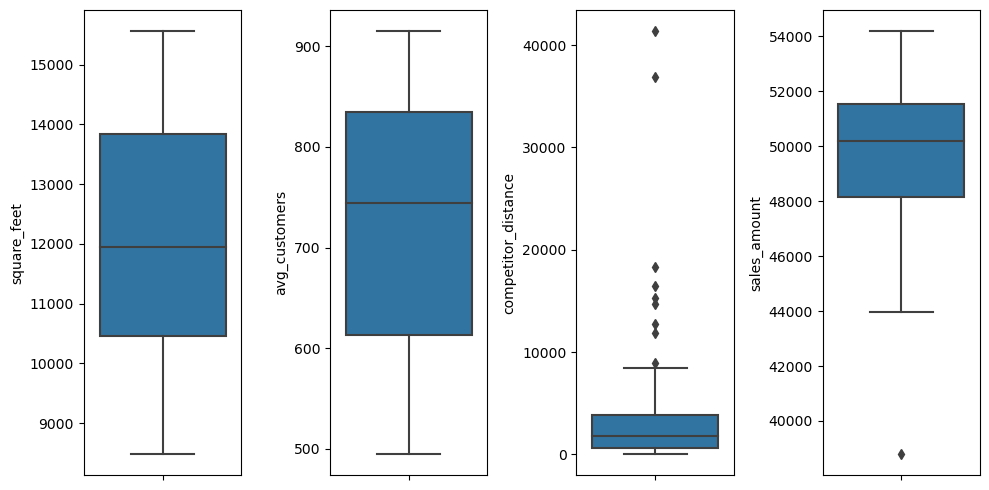

In [293]:
# boxplots

fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(10,5))
index = 0
ax = ax.flatten()

for k, v in hyper.items():
    sns.boxplot(y=k, data=hyper, ax=ax[index])
    index+=1
plt.tight_layout()

# percentages

print('HYPERMARKET OUTLIERS:')
for k, v in hyper.items():
    q1 = v.quantile(0.25)
    q3 = v.quantile(0.75)
    iqr = q3-q1
    outliers_hyper = v[(v <= q1 - 1.5*iqr) | (v >= q3 + 1.5*iqr)]
    print(f"The column {k} has {round(len(outliers_hyper)/len(v) * 100, 2)}%")

Let's see how much the outliers differs from the means.

In [294]:
mean_mini = mini[numeric_columns].mean()
print(f'The means of minimarkets is \n{mean_mini}')
print('The values of minimarkets outliers are')
merged_df.loc[outliers_mini.index.tolist()]

The means of minimarkets is 
square_feet             2008.757353
avg_customers            210.742647
competitor_distance     5092.426471
sales_amount           10049.246180
dtype: float64
The values of minimarkets outliers are


,id,country,market_type,square_feet,avg_customers,competitor_distance,has_promotions,sales_amount
84,GO20,FRANCE,MINI,2004,242.0,2396,YES,12509.045849
258,YX26,SPAIN,MINI,1744,236.0,227,YES,11805.644452
261,VX69,SPAIN,MINI,2230,236.0,1384,YES,11984.911603
273,NT69,FRANCE,MINI,2366,186.0,3749,YES,12321.102753
309,CI77,FRANCE,MINI,1568,151.0,2224,YES,11836.969040
352,VI75,FRANCE,MINI,2460,225.0,1141,YES,12420.954041
493,YR69,FRANCE,MINI,2539,162.0,955,YES,12420.098822
561,GW33,SPAIN,MINI,1613,193.0,1507,YES,11856.977795
681,KC39,FRANCE,MINI,2052,235.0,178,YES,12604.950329


In [295]:
mean_super = super[numeric_columns].mean()
print(f'The means of minimarkets is \n{mean_super}')
print('The values of supermarkets outliers are')
merged_df.loc[outliers_super.index.tolist()]

The means of minimarkets is 
square_feet             6054.496000
avg_customers            402.412000
competitor_distance     6716.372000
sales_amount           20841.111457
dtype: float64
The values of supermarkets outliers are


,id,country,market_type,square_feet,avg_customers,competitor_distance,has_promotions,sales_amount
102,NE99,ITALY,SUPER,6400,458.0,5097,YES,14961.625849


In [296]:
mean_hyper = hyper[numeric_columns].mean()
print(f'The mean of hypermarkets is \n{mean_hyper}')
print('The values of hypermarkets outliers are')
merged_df.loc[outliers_hyper.index.tolist()]

The mean of hypermarkets is 
square_feet            12114.619565
avg_customers            728.771739
competitor_distance     3881.684783
sales_amount           49740.694553
dtype: float64
The values of hypermarkets outliers are


,id,country,market_type,square_feet,avg_customers,competitor_distance,has_promotions,sales_amount
707,QQ62,ITALY,HYPER,10301,596.0,11895,YES,38796.890082


### Linear regression

In [297]:
merged_df

,id,country,market_type,square_feet,avg_customers,competitor_distance,has_promotions,sales_amount
0,XC14,SPAIN,HYPER,11135,773.0,515,YES,50309.539236
1,WG25,FRANCE,MINI,1402,252.0,522,YES,10418.686479
2,UX72,FRANCE,MINI,1452,265.0,15939,YES,10201.225137
3,EE84,SPAIN,HYPER,15259,874.0,754,YES,52161.938041
4,RF54,FRANCE,MINI,2497,191.0,34007,YES,9983.017178
...,...,...,...,...,...,...,...,...
745,ZM74,ITALY,SUPER,5778,356.0,4424,YES,19577.509603
746,WW60,FRANCE,HYPER,10923,907.0,41359,YES,50924.988233
747,LU14,ITALY,SUPER,5742,397.0,2841,YES,19612.729329
748,HY57,ITALY,MINI,2495,228.0,3848,YES,9446.582438


In [298]:
merged_df['has_promotions'] = merged_df['has_promotions'].map({'YES': 1, 'NO':0})
merged_df

,id,country,market_type,square_feet,avg_customers,competitor_distance,has_promotions,sales_amount
0,XC14,SPAIN,HYPER,11135,773.0,515,1,50309.539236
1,WG25,FRANCE,MINI,1402,252.0,522,1,10418.686479
2,UX72,FRANCE,MINI,1452,265.0,15939,1,10201.225137
3,EE84,SPAIN,HYPER,15259,874.0,754,1,52161.938041
4,RF54,FRANCE,MINI,2497,191.0,34007,1,9983.017178
...,...,...,...,...,...,...,...,...
745,ZM74,ITALY,SUPER,5778,356.0,4424,1,19577.509603
746,WW60,FRANCE,HYPER,10923,907.0,41359,1,50924.988233
747,LU14,ITALY,SUPER,5742,397.0,2841,1,19612.729329
748,HY57,ITALY,MINI,2495,228.0,3848,1,9446.582438


In [299]:
merged_df_dummies = pd.get_dummies(merged_df, columns=['market_type', 'country'], dtype=int )

merged_df_dummies

,id,square_feet,avg_customers,competitor_distance,has_promotions,sales_amount,market_type_HYPER,market_type_MINI,market_type_SUPER,country_FRANCE,country_ITALY,country_SPAIN
0,XC14,11135,773.0,515,1,50309.539236,1,0,0,0,0,1
1,WG25,1402,252.0,522,1,10418.686479,0,1,0,1,0,0
2,UX72,1452,265.0,15939,1,10201.225137,0,1,0,1,0,0
3,EE84,15259,874.0,754,1,52161.938041,1,0,0,0,0,1
4,RF54,2497,191.0,34007,1,9983.017178,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
745,ZM74,5778,356.0,4424,1,19577.509603,0,0,1,0,1,0
746,WW60,10923,907.0,41359,1,50924.988233,1,0,0,1,0,0
747,LU14,5742,397.0,2841,1,19612.729329,0,0,1,0,1,0
748,HY57,2495,228.0,3848,1,9446.582438,0,1,0,0,1,0


Linear regression with all the variables.

In [300]:
X = merged_df_dummies.loc[:,~(merged_df_dummies.columns.isin(['id', 'sales_amount']))]
y = merged_df_dummies['sales_amount']

# split between X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=999)

# Add a constant for the intercept to both training and test data
X_train_with_intercept = sm.add_constant(X_train)
X_test_with_intercept = sm.add_constant(X_test)

# Fit the linear regression model
model = sm.OLS(y_train, X_train_with_intercept).fit()


# coefficient estimates 
coefficients = model.params

# let's create a dataframe with all coefficients and stats of interest 
rows = []
for index, value in coefficients.items():
    row = [index, value, model.bse[index], model.tvalues[index], model.pvalues[index]]
    rows.append(row)

summary_coeff = pd.DataFrame(rows, columns=["", "OLS estimation", "SE", "t-stats", "p-value"])

# model accuracy

y_pred = model.predict(X_test_with_intercept)

# RSE
residuals = y_pred - y_test
RSE = (sum(residuals ** 2) / (len(residuals) - X.shape[1] - 1)) ** 0.5

# R2
R2 = 1 - ((y_test - y_pred) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum()

# MSE
MSE = ((y_test - y_pred) ** 2).mean()

print(f"The RSE is {round(RSE, 2)}, the R2 is {round(R2, 2)} and the MSE is {round(MSE, 2)}")
summary_coeff_all = summary_coeff
summary_coeff_all

The RSE is 745.44, the R2 is 1.0 and the MSE is 514932.15


,,OLS estimation,SE,t-stats,p-value
0,const,14373.568477,392.005369,36.666764,2.263006e-154
1,square_feet,0.206013,0.034149,6.032761,2.843972e-09
2,avg_customers,2.971920,0.515978,5.759777,1.355444e-08
3,competitor_distance,-0.009593,0.003870,-2.478539,1.347021e-02
4,has_promotions,94.679443,569.196545,0.166339,8.679473e-01
5,market_type_HYPER,25790.377822,325.800622,79.160002,9.040637e-317
6,market_type_MINI,-10377.169464,179.877057,-57.690345,5.839518e-245
7,market_type_SUPER,-1039.639880,129.121590,-8.051635,4.513814e-15
8,country_FRANCE,5599.622568,137.984352,40.581577,5.134674e-173
9,country_ITALY,3916.603289,142.697714,27.446854,1.485186e-107


Linear regression with all the variables, without outliers.

In [301]:
index_outliers_mini = outliers_mini.index.tolist()
median_mini = mini.loc[mini.index[~mini.index.isin(index_outliers_mini)]]['sales_amount'].median()
merged_df_dummies_no_outliers = merged_df_dummies
merged_df_dummies_no_outliers['sales_amount'][index_outliers_mini] = [median_mini for i in range(len(index_outliers_mini))]

C:\Users\Lucrezia\AppData\Local\Temp\ipykernel_1968\2490909543.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_dummies_no_outliers['sales_amount'][index_outliers_mini] = [median_mini for i in range(len(index_outliers_mini))]


In [302]:
index_outliers_super = outliers_super.index.tolist()
median_super = super.loc[super.index[~super.index.isin(index_outliers_super)]]['sales_amount'].median()
merged_df_dummies_no_outliers['sales_amount'][index_outliers_super] = [median_super for i in range(len(index_outliers_super))]

C:\Users\Lucrezia\AppData\Local\Temp\ipykernel_1968\3840152333.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_dummies_no_outliers['sales_amount'][index_outliers_super] = [median_super for i in range(len(index_outliers_super))]


In [303]:
index_outliers_hyper = outliers_hyper.index.tolist()
median_hyper = hyper.loc[hyper.index[~hyper.index.isin(index_outliers_hyper)]]['sales_amount'].median()
merged_df_dummies_no_outliers['sales_amount'][index_outliers_hyper] = [median_hyper for i in range(len(index_outliers_hyper))]

C:\Users\Lucrezia\AppData\Local\Temp\ipykernel_1968\3443088098.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_dummies_no_outliers['sales_amount'][index_outliers_hyper] = [median_hyper for i in range(len(index_outliers_hyper))]


In [304]:
merged_df_dummies_no_outliers.loc[:,(~merged_df_dummies_no_outliers.columns.isin(['id', 'sales_amount', 'has_promotions']))]

,square_feet,avg_customers,competitor_distance,market_type_HYPER,market_type_MINI,market_type_SUPER,country_FRANCE,country_ITALY,country_SPAIN
0,11135,773.0,515,1,0,0,0,0,1
1,1402,252.0,522,0,1,0,1,0,0
2,1452,265.0,15939,0,1,0,1,0,0
3,15259,874.0,754,1,0,0,0,0,1
4,2497,191.0,34007,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...
745,5778,356.0,4424,0,0,1,0,1,0
746,10923,907.0,41359,1,0,0,1,0,0
747,5742,397.0,2841,0,0,1,0,1,0
748,2495,228.0,3848,0,1,0,0,1,0


In [305]:
X = merged_df_dummies_no_outliers.loc[:,(~merged_df_dummies_no_outliers.columns.isin(['id', 'sales_amount']))]
y = merged_df_dummies_no_outliers['sales_amount']

# split between X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=999)

# Add a constant for the intercept to both training and test data
X_train_with_intercept = sm.add_constant(X_train)
X_test_with_intercept = sm.add_constant(X_test)

# Fit the linear regression model
model = sm.OLS(y_train, X_train_with_intercept).fit()


# coefficient estimates 
coefficients = model.params

# let's create a dataframe with all coefficients and stats of interest 
rows = []
for index, value in coefficients.items():
    row = [index, value, model.bse[index], model.tvalues[index], model.pvalues[index]]
    rows.append(row)

summary_coeff = pd.DataFrame(rows, columns=["", "OLS estimation", "SE", "t-stats", "p-value"])

# model accuracy

y_pred = model.predict(X_test_with_intercept)

# RSE
residuals = y_pred - y_test
RSE = (sum(residuals ** 2) / (len(residuals) - X.shape[1] - 1)) ** 0.5

# R2
R2 = 1 - ((y_test - y_pred) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum()

# MSE
MSE = ((y_test - y_pred) ** 2).mean()

print(f"The RSE is {round(RSE, 2)}, the R2 is {round(R2, 2)} and the MSE is {round(MSE, 2)}")
summary_coeff

The RSE is 744.83, the R2 is 1.0 and the MSE is 514082.58


,,OLS estimation,SE,t-stats,p-value
0,const,14758.380777,314.938734,46.861117,3.429972e-201
1,square_feet,0.168244,0.027435,6.132383,1.584572e-09
2,avg_customers,2.481168,0.414539,5.985366,3.745853e-09
3,competitor_distance,-0.005560,0.003110,-1.787941,7.429781e-02
4,has_promotions,-35.713512,457.294857,-0.078097,9.377771e-01
5,market_type_HYPER,26390.810322,261.749566,100.824657,0.000000e+00
6,market_type_MINI,-10649.200878,144.513971,-73.689767,4.430608e-300
7,market_type_SUPER,-983.228667,103.736819,-9.478107,6.185704e-20
8,country_FRANCE,5683.435826,110.857199,51.268081,1.037061e-219
9,country_ITALY,4149.482898,114.643933,36.194527,4.554250e-152


R $^2$ is 1, and this is too much perfect... Overfitting? Are you?

### Confidence intervals

In [306]:
# 95% confidence intervals
confidence_intervals = model.conf_int(alpha=0.05)  # 0.05 for a 95% confidence interval

for index, value in coefficients.items():
    conf_int_tmp = confidence_intervals.loc[index].values
    print(f"The 95% confidence interval for {index} is {conf_int_tmp}")


The 95% confidence interval for const is [14139.84549014 15376.91606381]
The 95% confidence interval for square_feet is [0.1143617  0.22212725]
The 95% confidence interval for avg_customers is [1.66701922 3.29531725]
The 95% confidence interval for competitor_distance is [-0.01166674  0.00054742]
The 95% confidence interval for has_promotions is [-933.83424321  862.40721887]
The 95% confidence interval for market_type_HYPER is [25876.73781914 26904.88282482]
The 95% confidence interval for market_type_MINI is [-10933.02430485 -10365.37745172]
The 95% confidence interval for market_type_SUPER is [-1186.9663348   -779.49099865]
The 95% confidence interval for country_FRANCE is [5465.71383022 5901.15782089]
The 95% confidence interval for country_ITALY is [3924.32380954 4374.64198587]
The 95% confidence interval for country_SPAIN is [4707.05334216 5143.87076526]


Let's see:
1. correlation of error terms
2. if the variance of error terms is constant
3. if there is collinearity among predictors

Text(0, 0.5, 'Training residuals')

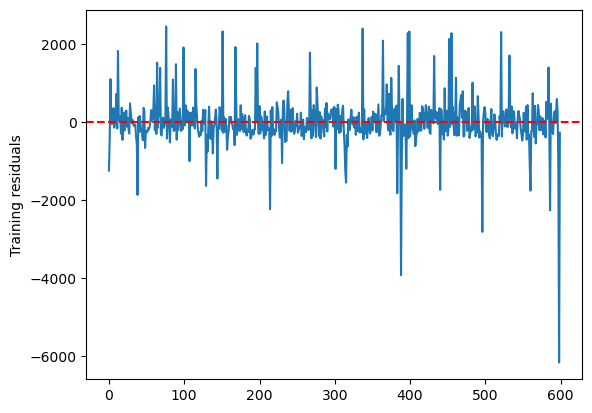

In [307]:
# 1. correlation of error terms

residuals_training = model.resid # notice that these are residuals from training data, not test data
plt.plot(range(0, len(residuals_training)), residuals_training)
plt.axhline(y=0, color="red", linestyle="--")
plt.ylabel("Training residuals")

There is not a discernible pattern, so the errors are not correlated.

To quantify the correlation there are multiple options:
- compute the autocorrelation with lagged-1 residuals: this returns a number from 0 to 1, the closer to 0 the stronger is the non-correlation
- compute Durbin-Watson: this returns a number from 0 to 4, the closer to 2 the stronger is the non-correlation

In [308]:
# autocorrelation
lagged_residuals = residuals_training.shift(1)  # Lagged residuals
autocorrelation = (residuals_training.corr(lagged_residuals)) ** 2

# durbin_watson
durbin_watson = sm.stats.durbin_watson(residuals_training)

print(f"The autocorrelation is {round(autocorrelation, 5)} \nwhile the durbing watson statistic is {round(durbin_watson, 5)}, \nsuggesting that error terms are not correlated")

The autocorrelation is 0.0017 
while the durbing watson statistic is 1.91119, 
suggesting that error terms are not correlated


The Breusch-Pagan Lagrange Multiplier test can be used to identify heteroscedasticity (non-constant variance). 

The test assumes homoscedasticity (this is the null hypothesis) which means that the residual variance does not depend on the values of the variables in x

Text(0, 0.5, 'Training residuals')

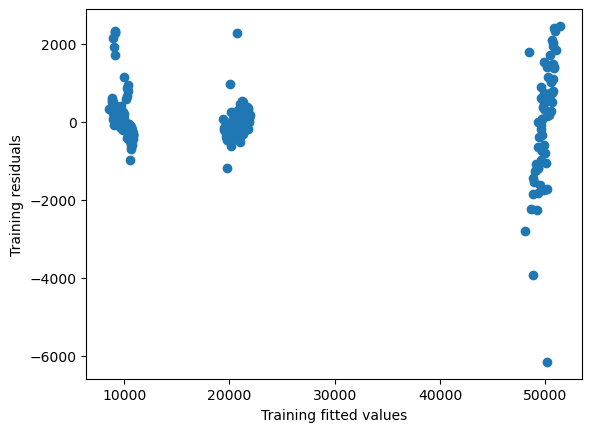

In [309]:
# 2. Variance of error terms

# let's first plot residuals vs fitted values
plt.scatter(model.predict(X_train_with_intercept), residuals_training)
plt.xlabel("Training fitted values")
plt.ylabel("Training residuals")

In [310]:
name = ['Lagrange multiplier statistic', 'p-value']
test = sm.stats.het_breuschpagan(residuals_training, model.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 98.96922024233139),
 ('p-value', 8.761539011166448e-17)]

Since p-value is < 0.05 we have indication of heteroscedasticity (reject null hypothesis)

Last step, let's measure collinearity using VIF

In [311]:
# 3. Collinearity

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["Feature"] = X_train.columns
vif


c:\Users\Lucrezia\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,VIF Factor,Feature
0,12.635024,square_feet
1,7.885660,avg_customers
2,1.023613,competitor_distance
3,1.017313,has_promotions
4,inf,market_type_HYPER
5,inf,market_type_MINI
6,inf,market_type_SUPER
7,inf,country_FRANCE
8,inf,country_ITALY
9,inf,country_SPAIN


There is a problematic amount of collinearity for all variables excpet for competitor_distance and has_promotion.

Lest's split into three datasets the original one, containing the same market_type and see how they behave.

### Linear regession for MINI, SUPER, HYPER datasets.

In [312]:
merged_mini = merged_df.loc[merged_df['market_type']=='MINI']
merged_super = merged_df.loc[merged_df['market_type']=='SUPER']
merged_hyper = merged_df.loc[merged_df['market_type']=='HYPER']

Regression of mini

In [313]:
merged_mini_dummies = pd.get_dummies(merged_mini, columns=['country'], dtype=int)
merged_mini_dummies.columns

# drop_first=False

Index(['id', 'market_type', 'square_feet', 'avg_customers',
       'competitor_distance', 'has_promotions', 'sales_amount',
       'country_FRANCE', 'country_ITALY', 'country_SPAIN'],
      dtype='object')

In [314]:
X = merged_mini_dummies.loc[:,(~merged_mini_dummies.columns.isin(['id','market_type','sales_amount']))]
y = merged_mini_dummies['sales_amount']

# split between X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=999)

# Add a constant for the intercept to both training and test data
X_train_with_intercept = sm.add_constant(X_train)
X_test_with_intercept = sm.add_constant(X_test)

# Fit the linear regression model
model = sm.OLS(y_train, X_train_with_intercept).fit()


# coefficient estimates 
coefficients = model.params

# let's create a dataframe with all coefficients and stats of interest 
rows = []
for index, value in coefficients.items():
    row = [index, value, model.bse[index], model.tvalues[index], model.pvalues[index]]
    rows.append(row)

summary_coeff = pd.DataFrame(rows, columns=["", "OLS estimation", "SE", "t-stats", "p-value"])


# model accuracy

y_pred = model.predict(X_test_with_intercept)

# RSE
residuals = y_pred - y_test
RSE = (sum(residuals ** 2) / (len(residuals) - X.shape[1] - 1)) ** 0.5

# R2
R2 = 1 - ((y_test - y_pred) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum()

# MSE
MSE = ((y_test - y_pred) ** 2).mean()

print(f"The RSE is {round(RSE, 2)}, the R2 is {round(R2, 2)} and the MSE is {round(MSE, 2)}")

summary_coeff_mini = summary_coeff
summary_coeff_mini

The RSE is 522.46, the R2 is 0.42 and the MSE is 246329.42


,,OLS estimation,SE,t-stats,p-value
0,const,7029.617598,311.137317,22.593296,3.641394e-68
1,square_feet,0.111931,0.059213,1.890309,5.962291e-02
2,avg_customers,1.207125,0.551927,2.187111,2.946018e-02
3,competitor_distance,-0.003993,0.002335,-1.710122,8.821558e-02
4,has_promotions,95.102628,376.659507,0.252490,8.008252e-01
5,country_FRANCE,2781.247732,108.135658,25.719987,8.953241e-80
6,country_ITALY,1879.596070,111.122677,16.914604,2.908084e-46
7,country_SPAIN,2368.773796,105.980518,22.351030,3.008890e-67


In [315]:
# Collinearity

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["Feature"] = X_train.columns
vif


,VIF Factor,Feature
0,1.033737,square_feet
1,1.023487,avg_customers
2,1.001748,competitor_distance
3,1.024742,has_promotions
4,212.487030,country_FRANCE
5,116.939745,country_ITALY
6,80.214733,country_SPAIN


Regression of super 

In [316]:
merged_super_dummies = pd.get_dummies(merged_super, columns=['country'], dtype=int)
merged_super_dummies.columns

Index(['id', 'market_type', 'square_feet', 'avg_customers',
       'competitor_distance', 'has_promotions', 'sales_amount',
       'country_FRANCE', 'country_ITALY', 'country_SPAIN'],
      dtype='object')

In [317]:
X = merged_super_dummies.loc[:,(~merged_super_dummies.columns.isin(['id','market_type','sales_amount']))]
y = merged_super_dummies['sales_amount']

# split between X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=999)

# Add a constant for the intercept to both training and test data
X_train_with_intercept = sm.add_constant(X_train)
X_test_with_intercept = sm.add_constant(X_test)

# Fit the linear regression model
model = sm.OLS(y_train, X_train_with_intercept).fit()


# coefficient estimates 
coefficients = model.params

# let's create a dataframe with all coefficients and stats of interest 
rows = []
for index, value in coefficients.items():
    row = [index, value, model.bse[index], model.tvalues[index], model.pvalues[index]]
    rows.append(row)

summary_coeff = pd.DataFrame(rows, columns=["", "OLS estimation", "SE", "t-stats", "p-value"])


# model accuracy

y_pred = model.predict(X_test_with_intercept)

# RSE
residuals = y_pred - y_test
RSE = (sum(residuals ** 2) / (len(residuals) - X.shape[1] - 1)) ** 0.5

# R2
R2 = 1 - ((y_test - y_pred) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum()

# MSE
MSE = ((y_test - y_pred) ** 2).mean()

print(f"The RSE is {round(RSE, 2)}, the R2 is {round(R2, 2)} and the MSE is {round(MSE, 2)}")

summary_coeff_super = summary_coeff
summary_coeff_super

The RSE is 181.0, the R2 is 0.96 and the MSE is 27518.27


,,OLS estimation,SE,t-stats,p-value
0,square_feet,0.096018,0.031121,3.085316,2.330427e-03
1,avg_customers,2.048939,0.470896,4.351151,2.187588e-05
2,competitor_distance,-0.010370,0.005322,-1.948590,5.278663e-02
3,has_promotions,14433.343408,209.925023,68.754755,3.563380e-138
4,country_FRANCE,5781.704653,82.332975,70.223439,6.910500e-140
5,country_ITALY,3793.353994,88.500835,42.862353,6.985375e-101
6,country_SPAIN,4858.284761,85.286145,56.964525,4.501196e-123


In [318]:
# Collinearity

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["Feature"] = X_train.columns
vif


c:\Users\Lucrezia\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\Lucrezia\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,VIF Factor,Feature
0,1.009313,square_feet
1,1.010134,avg_customers
2,1.010606,competitor_distance
3,0.000000,has_promotions
4,inf,country_FRANCE
5,inf,country_ITALY
6,inf,country_SPAIN


Regression of hyper

In [319]:
merged_hyper_dummies = pd.get_dummies(merged_hyper, columns=['country'], dtype=int)
merged_hyper_dummies.columns

Index(['id', 'market_type', 'square_feet', 'avg_customers',
       'competitor_distance', 'has_promotions', 'sales_amount',
       'country_FRANCE', 'country_ITALY', 'country_SPAIN'],
      dtype='object')

In [320]:
X = merged_hyper_dummies.loc[:,(~merged_hyper_dummies.columns.isin(['id','market_type','sales_amount']))]
y = merged_hyper_dummies['sales_amount']

# split between X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=999)

# Add a constant for the intercept to both training and test data
X_train_with_intercept = sm.add_constant(X_train)
X_test_with_intercept = sm.add_constant(X_test)

# Fit the linear regression model
model = sm.OLS(y_train, X_train_with_intercept).fit()


# coefficient estimates 
coefficients = model.params

# let's create a dataframe with all coefficients and stats of interest 
rows = []
for index, value in coefficients.items():
    row = [index, value, model.bse[index], model.tvalues[index], model.pvalues[index]]
    rows.append(row)

summary_coeff = pd.DataFrame(rows, columns=["", "OLS estimation", "SE", "t-stats", "p-value"])


# model accuracy

y_pred = model.predict(X_test_with_intercept)

# RSE
residuals = y_pred - y_test
RSE = (sum(residuals ** 2) / (len(residuals) - X.shape[1] - 1)) ** 0.5

# R2
R2 = 1 - ((y_test - y_pred) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum()

# MSE
MSE = ((y_test - y_pred) ** 2).mean()

print(f"The RSE is {round(RSE, 2)}, the R2 is {round(R2, 2)} and the MSE is {round(MSE, 2)}")
summary_coeff_hyper = summary_coeff
summary_coeff_hyper

The RSE is 2051.96, the R2 is 0.62 and the MSE is 2437686.6


,,OLS estimation,SE,t-stats,p-value
0,square_feet,0.335571,0.056458,5.943728,1.110950e-07
1,avg_customers,6.860295,1.023356,6.703725,5.117150e-09
2,competitor_distance,-0.074155,0.020717,-3.579406,6.461868e-04
3,has_promotions,30700.599305,746.786895,41.110255,2.942308e-49
4,country_FRANCE,12809.735406,269.786477,47.481014,2.594441e-53
5,country_ITALY,7630.669765,307.230953,24.836917,1.624915e-35
6,country_SPAIN,10260.194134,324.634785,31.605344,5.571767e-42


In [321]:
# Collinearity

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["Feature"] = X_train.columns
vif


c:\Users\Lucrezia\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\Lucrezia\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,VIF Factor,Feature
0,1.005060,square_feet
1,1.186012,avg_customers
2,1.020045,competitor_distance
3,0.000000,has_promotions
4,inf,country_FRANCE
5,inf,country_ITALY
6,inf,country_SPAIN


The VIF values are all near to 1, so there is less collinearity in splitted datasets. Fo this reason we decide to do the following analysis on them separately.

### Feature selection

Feature selection MINI

In [322]:
# Step 1: initialize KFold object to use for model evaluation
number_folds = 5
kf = KFold(n_splits=number_folds, shuffle=True, random_state=999)

# Step 2: Load the dataset
X = merged_mini_dummies.loc[:,(~merged_mini_dummies.columns.isin(['id', 'market_type', 'sales_amount']))]
y = merged_mini_dummies['sales_amount']

# Step 3: Define a function to calculate RSE, R2, and MSE
def calculate_metrics(y_validation, y_pred, X):
    residuals = y_validation - y_pred
    RSE = (sum(residuals ** 2) / (len(residuals) - X.shape[1] - 1)) ** 0.5
    R2 = 1 - (residuals ** 2).sum() / ((y_validation - y_validation.mean()) ** 2).sum()
    MSE = (residuals ** 2).mean()
    return RSE, R2, MSE

# Step 4: Implement best subset selection
def best_subset_selection(X, y, target_col):
    n_features = X.shape[1]
    all_models = []
    best_models = []
    best_metrics = {
        "RSE": float("inf"),
        "R2": -float("inf"),
        "MSE": float("inf"),
    }

    # for each number of features
    for k in range(1, n_features + 1):
        print(f"start iteration {k} of {n_features}")
        # for each combination of k number of features
        for combo in itertools.combinations(X.columns, k):
            model_features = list(combo)
            X_subset = X[model_features]
            # Add a constant for the intercept term
            X_subset = sm.add_constant(X_subset)  
            # initialize empty array to store mse for each fold
            mse_folds = []
            # for each fold fit the model
            for train_idx, validation_idx in kf.split(X_subset):
                X_train, X_validation = X_subset.iloc[train_idx], X_subset.iloc[validation_idx]
                y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]
                model = sm.OLS(y_train, X_train).fit()
                y_pred = model.predict(X_validation)
                RSE, R2, MSE = calculate_metrics(y_validation, y_pred, X[model_features])
                mse_folds.append(MSE)
            # estimate test error using the mean of MSE in all folds
            test_error_estimated = sum(mse_folds) / len(mse_folds)
            # if the estimation of the test error is reduced, save metrics and model
            if test_error_estimated < best_metrics["MSE"]:
                best_metrics["RSE"] = RSE
                best_metrics["R2"] = R2
                best_metrics["MSE"] = test_error_estimated
                best_models = model_features
            # save number of features and estimated test error for plotting
            all_models.append([len(list(combo)), test_error_estimated])

    return best_models, best_metrics, all_models

# Step 5: Calculate and display statistics for each model
best_features, best_metrics, all_models = best_subset_selection(X, y, 'sales_amount')

print("-------------------")
print("Finished!")
print("Features with best model:", best_features)
print("RSE:", best_metrics["RSE"])
print("R2:", best_metrics["R2"])
print("MSE:", best_metrics["MSE"])

start iteration 1 of 7
start iteration 2 of 7
start iteration 3 of 7
start iteration 4 of 7
start iteration 5 of 7
start iteration 6 of 7
start iteration 7 of 7
-------------------
Finished!
Features with best model: ['square_feet', 'avg_customers', 'competitor_distance', 'country_ITALY', 'country_SPAIN']
RSE: 373.236912113722
R2: 0.6126424530470195
MSE: 160241.62595750423


The column 'has_promotion' is not in the best features selection, so we will not use it in the regressions.

Feature selection SUPER

In [323]:
# Step 1: initialize KFold object to use for model evaluation
number_folds = 5
kf = KFold(n_splits=number_folds, shuffle=True, random_state=999)

# Step 2: Load the dataset
X = merged_super_dummies.loc[:,(~merged_super_dummies.columns.isin(['id', 'market_type', 'sales_amount']))]
y = merged_super_dummies['sales_amount']

# Step 3: Define a function to calculate RSE, R2, and MSE
def calculate_metrics(y_validation, y_pred, X):
    residuals = y_validation - y_pred
    RSE = (sum(residuals ** 2) / (len(residuals) - X.shape[1] - 1)) ** 0.5
    R2 = 1 - (residuals ** 2).sum() / ((y_validation - y_validation.mean()) ** 2).sum()
    MSE = (residuals ** 2).mean()
    return RSE, R2, MSE

# Step 4: Implement best subset selection
def best_subset_selection(X, y, target_col):
    n_features = X.shape[1]
    all_models = []
    best_models = []
    best_metrics = {
        "RSE": float("inf"),
        "R2": -float("inf"),
        "MSE": float("inf"),
    }

    # for each number of features
    for k in range(1, n_features + 1):
        print(f"start iteration {k} of {n_features}")
        # for each combination of k number of features
        for combo in itertools.combinations(X.columns, k):
            model_features = list(combo)
            X_subset = X[model_features]
            # Add a constant for the intercept term
            X_subset = sm.add_constant(X_subset)  
            # initialize empty array to store mse for each fold
            mse_folds = []
            # for each fold fit the model
            for train_idx, validation_idx in kf.split(X_subset):
                X_train, X_validation = X_subset.iloc[train_idx], X_subset.iloc[validation_idx]
                y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]
                model = sm.OLS(y_train, X_train).fit()
                y_pred = model.predict(X_validation)
                RSE, R2, MSE = calculate_metrics(y_validation, y_pred, X[model_features])
                mse_folds.append(MSE)
            # estimate test error using the mean of MSE in all folds
            test_error_estimated = sum(mse_folds) / len(mse_folds)
            # if the estimation of the test error is reduced, save metrics and model
            if test_error_estimated < best_metrics["MSE"]:
                best_metrics["RSE"] = RSE
                best_metrics["R2"] = R2
                best_metrics["MSE"] = test_error_estimated
                best_models = model_features
            # save number of features and estimated test error for plotting
            all_models.append([len(list(combo)), test_error_estimated])

    return best_models, best_metrics, all_models

# Step 5: Calculate and display statistics for each model
best_features, best_metrics, all_models = best_subset_selection(X, y, 'sales_amount')

print("-------------------")
print("Finished!")
print("Features with best model:", best_features)
print("RSE:", best_metrics["RSE"])
print("R2:", best_metrics["R2"])
print("MSE:", best_metrics["MSE"])

start iteration 1 of 7
start iteration 2 of 7
start iteration 3 of 7
start iteration 4 of 7
start iteration 5 of 7
start iteration 6 of 7
start iteration 7 of 7
-------------------
Finished!
Features with best model: ['square_feet', 'avg_customers', 'competitor_distance', 'has_promotions', 'country_ITALY', 'country_SPAIN']
RSE: 158.0117799830079
R2: 0.9699057781045344
MSE: 182037.28128359205


Here we have no changes.

Feature selection HYPER

In [324]:
# Step 1: initialize KFold object to use for model evaluation
number_folds = 5
kf = KFold(n_splits=number_folds, shuffle=True, random_state=999)

# Step 2: Load the dataset
X = merged_hyper_dummies.loc[:,(~merged_super_dummies.columns.isin(['id', 'market_type', 'sales_amount']))]
y = merged_hyper_dummies['sales_amount']

# Step 3: Define a function to calculate RSE, R2, and MSE
def calculate_metrics(y_validation, y_pred, X):
    residuals = y_validation - y_pred
    RSE = (sum(residuals ** 2) / (len(residuals) - X.shape[1] - 1)) ** 0.5
    R2 = 1 - (residuals ** 2).sum() / ((y_validation - y_validation.mean()) ** 2).sum()
    MSE = (residuals ** 2).mean()
    return RSE, R2, MSE

# Step 4: Implement best subset selection
def best_subset_selection(X, y, target_col):
    n_features = X.shape[1]
    all_models = []
    best_models = []
    best_metrics = {
        "RSE": float("inf"),
        "R2": -float("inf"),
        "MSE": float("inf"),
    }

    # for each number of features
    for k in range(1, n_features + 1):
        print(f"start iteration {k} of {n_features}")
        # for each combination of k number of features
        for combo in itertools.combinations(X.columns, k):
            model_features = list(combo)
            X_subset = X[model_features]
            # Add a constant for the intercept term
            X_subset = sm.add_constant(X_subset)  
            # initialize empty array to store mse for each fold
            mse_folds = []
            # for each fold fit the model
            for train_idx, validation_idx in kf.split(X_subset):
                X_train, X_validation = X_subset.iloc[train_idx], X_subset.iloc[validation_idx]
                y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]
                model = sm.OLS(y_train, X_train).fit()
                y_pred = model.predict(X_validation)
                RSE, R2, MSE = calculate_metrics(y_validation, y_pred, X[model_features])
                mse_folds.append(MSE)
            # estimate test error using the mean of MSE in all folds
            test_error_estimated = sum(mse_folds) / len(mse_folds)
            # if the estimation of the test error is reduced, save metrics and model
            if test_error_estimated < best_metrics["MSE"]:
                best_metrics["RSE"] = RSE
                best_metrics["R2"] = R2
                best_metrics["MSE"] = test_error_estimated
                best_models = model_features
            # save number of features and estimated test error for plotting
            all_models.append([len(list(combo)), test_error_estimated])

    return best_models, best_metrics, all_models

# Step 5: Calculate and display statistics for each model
best_features, best_metrics, all_models = best_subset_selection(X, y, 'sales_amount')

print("-------------------")
print("Finished!")
print("Features with best model:", best_features)
print("RSE:", best_metrics["RSE"])
print("R2:", best_metrics["R2"])
print("MSE:", best_metrics["MSE"])

start iteration 1 of 7
start iteration 2 of 7
start iteration 3 of 7
start iteration 4 of 7
start iteration 5 of 7
start iteration 6 of 7
start iteration 7 of 7
-------------------
Finished!
Features with best model: ['square_feet', 'avg_customers', 'competitor_distance', 'has_promotions', 'country_ITALY', 'country_SPAIN']
RSE: 2323.9281810854436
R2: 0.6825699681478798
MSE: 1336769.2917880986


Here we have no chages.

### Objective 1: Delta changes

The delta chages of minimarkets sales amounts are explained by the beta coefficients. It means that if we add one unit to a variable and leave the other constant, the increase (or the decrease) in the target is given by the following values. 

In [326]:
summary_coeff_mini[['','OLS estimation']]

,,OLS estimation
0,const,7029.617598
1,square_feet,0.111931
2,avg_customers,1.207125
3,competitor_distance,-0.003993
4,has_promotions,95.102628
5,country_FRANCE,2781.247732
6,country_ITALY,1879.596070
7,country_SPAIN,2368.773796


In [327]:
summary_coeff_super[['','OLS estimation']]

,,OLS estimation
0,square_feet,0.096018
1,avg_customers,2.048939
2,competitor_distance,-0.010370
3,has_promotions,14433.343408
4,country_FRANCE,5781.704653
5,country_ITALY,3793.353994
6,country_SPAIN,4858.284761


In [328]:
summary_coeff_hyper[['','OLS estimation']]

,,OLS estimation
0,square_feet,0.335571
1,avg_customers,6.860295
2,competitor_distance,-0.074155
3,has_promotions,30700.599305
4,country_FRANCE,12809.735406
5,country_ITALY,7630.669765
6,country_SPAIN,10260.194134


### Objective 2: choose the best option using more than one method

#### Multilinear regression

In [199]:
# mini

newdata_mini_spain = [1850, 190, 4500, 0, 0, 1]
newdata_mini_france = [2100, 215, 1850, 1, 0, 0]
newdata_mini_italy = [1920, 220, 14500, 0, 1, 0]

newdata_mini = pd.DataFrame([newdata_mini_spain, newdata_mini_france, newdata_mini_italy])
newdata_mini.columns = numeric_columns[0:3] + ['country_FRANCE', 'country_ITALY', 'country_SPAIN']
newdata_mini


,square_feet,avg_customers,competitor_distance,country_FRANCE,country_ITALY,country_SPAIN
0,1850,190,4500,0,0,1
1,2100,215,1850,1,0,0
2,1920,220,14500,0,1,0


For the MINI and SUPER dataset we include also has_promotion.

In [201]:
newdata_super_spain = [5880, 420, 580, 1, 0, 0, 1]
newdata_super_france = [5120, 390, 2560, 1, 1, 0, 0]
newdata_super_italy = [4970, 410, 3520, 1, 0, 1, 0]

newdata_super = pd.DataFrame([newdata_super_spain, newdata_super_france, newdata_super_italy])
newdata_super.columns = numeric_columns[0:3]+['has_promotions'] + ['country_FRANCE', 'country_ITALY', 'country_SPAIN']
newdata_super


,square_feet,avg_customers,competitor_distance,has_promotions,country_FRANCE,country_ITALY,country_SPAIN
0,5880,420,580,1,0,0,1
1,5120,390,2560,1,1,0,0
2,4970,410,3520,1,0,1,0


In [202]:
newdata_hyper_spain = [10560, 860, 8940, 1, 0, 0, 1]
newdata_hyper_france = [12570, 880, 7580, 1, 1, 0, 0]
newdata_hyper_italy = [11980, 790, 11560, 1, 0, 1, 0]

newdata_hyper = pd.DataFrame([newdata_hyper_spain, newdata_hyper_france, newdata_hyper_italy])
newdata_hyper.columns = numeric_columns[0:3]+['has_promotions'] + ['country_FRANCE', 'country_ITALY', 'country_SPAIN']
newdata_hyper


,square_feet,avg_customers,competitor_distance,has_promotions,country_FRANCE,country_ITALY,country_SPAIN
0,10560,860,8940,1,0,0,1
1,12570,880,7580,1,1,0,0
2,11980,790,11560,1,0,1,0


#### K-fold cross-validation for OLS

In [331]:
print('MINI')
# Features and target variable
X = merged_mini_dummies.loc[:,(~merged_mini_dummies.columns.isin(['id','market_type','sales_amount','has_promotions']))]
y = merged_mini_dummies['sales_amount']

# Number of folds for cross-validation
num_folds = 5

# Initialize KFold with the number of folds
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Lists to store results
mse_scores = []
predictions = []

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the OLS model on the training data
    model = sm.OLS(y_train, X_train)
    results = model.fit()

    # Make predictions on the test set
    y_pred = results.predict(X_test)

    # Calculate mean squared error and store it
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)

    # Display OLS summary for each fold (optional)
    predict = results.predict(newdata_mini)
    predictions.append(predict)

MSE_mini_lr = np.mean(mse_scores)
print(f'Mean Squared Error: {MSE_mini_lr}')

array_predictions = np.array(predictions)
predictions_mini_lr = np.mean(array_predictions, axis=0).tolist()
print(predictions_mini_lr)


print('------------------------------------------------------------------')

print('SUPER')
# Features and target variable
X = merged_super_dummies.loc[:,(~merged_super_dummies.columns.isin(['id','market_type','sales_amount']))]
y = merged_super_dummies['sales_amount']

# Number of folds for cross-validation
num_folds = 5

# Initialize KFold with the number of folds
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Lists to store results
mse_scores = []
predictions = []

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the OLS model on the training data
    model = sm.OLS(y_train, X_train)
    results = model.fit()

    # Make predictions on the test set
    y_pred = results.predict(X_test)

    # Calculate mean squared error and store it
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)

    # Display OLS summary for each fold (optional)
    # print(results.summary())
    params = results.params.tolist()
    coeff = coeff+params
    
    predict = results.predict(newdata_super)
    predictions.append(predict)

# Display the mean of all mean squared errors
MSE_super_lr = np.mean(mse_scores)
print(f'Mean Mean Squared Error: {MSE_super_lr}')

array_predictions = np.array(predictions)
predictions_super_lr = np.mean(array_predictions, axis=0).tolist()
print(predictions_super_lr)


print('------------------------------------------------------------------')

print('HYPER')
# Features and target variable
X = merged_hyper_dummies.loc[:,(~merged_hyper_dummies.columns.isin(['id','market_type','sales_amount']))]
y = merged_hyper_dummies['sales_amount']

# Number of folds for cross-validation
num_folds = 5

# Initialize KFold with the number of folds
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Lists to store results
mse_scores = []
coeff = []
predictions = []

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the OLS model on the training data
    model = sm.OLS(y_train, X_train)
    results = model.fit()

    # Make predictions on the test set
    y_pred = results.predict(X_test)

    # Calculate mean squared error and store it
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)

    # Append the new list of predictions
    predict = results.predict(newdata_hyper)
    predictions.append(predict)

# Display the mean of all mean squared errors
MSE_hyper_lr = np.mean(mse_scores)
print(f'Mean Mean Squared Error: {MSE_hyper_lr}')

array_predictions = np.array(predictions)
predictions_hyper_lr = np.mean(array_predictions, axis=0).tolist()
print(predictions_hyper_lr)




MINI
Mean Squared Error: 163957.9437188777
[9896.824680173162, 10421.423099231957, 9432.659130326389]
------------------------------------------------------------------
SUPER
Mean Mean Squared Error: 187400.14794570388
[20703.636238502113, 21491.474311594677, 19521.183695002575]
------------------------------------------------------------------
HYPER
Mean Mean Squared Error: 1360546.6738589075
[49662.90544750598, 53123.78006290235, 47057.018592358705]


#### Polynomial Regression

In [332]:
print('MINI')
# split data into X and Y
X = merged_mini_dummies.loc[:,(~merged_mini_dummies.columns.isin(['id','market_type' ,'sales_amount', 'has_promotions']))]
y = merged_mini_dummies['sales_amount']

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
# check if features have been standardized
for col in X_scaled.columns:
    print(f"The column {col} has mean {round(X_scaled[col].mean(), 2)} and variance {round(X_scaled[col].var(), 2)}")

# Number of splits for k-fold cross-validation
k = 5  

# Split the data into k folds manually
kf = KFold(n_splits=k, shuffle=True, random_state=99)

# Initialize an array to store MSE values for each fold
mse_folds = []

# run k-fold cv
for train_idx, validation_idx in kf.split(X_scaled):
    X_train, X_validation = X_scaled.iloc[train_idx], X_scaled.iloc[validation_idx]
    y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]

    # polynomial degree 2
    poly = PolynomialFeatures(2)
    X_train_poly = poly.fit_transform(X_train) # print the columns of X_train_poly: how many columns do you expect? check the documentation to understand why there are so many columns!
    X_validation_poly = poly.fit_transform(X_validation)

    # fit model
    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    # get predictions
    y_pred = model.predict(X_validation_poly)
    current_mse = ((y_validation - y_pred)**2).mean()
    mse_folds.append(current_mse)

   
# Calculate the mean MSE across folds
MSE_mini_pr = sum(mse_folds) / len(mse_folds)
print(f"The estimated test MSE error is {round(MSE_mini_pr, 2)}")


print('------------------------------------------------------------------')

print('SUPER')
# split data into X and Y
X = merged_super_dummies.loc[:,(~merged_super_dummies.columns.isin(['id','market_type' ,'sales_amount']))]
y = merged_super_dummies['sales_amount']

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
# check if features have been standardized
for col in X_scaled.columns:
    print(f"The column {col} has mean {round(X_scaled[col].mean(), 2)} and variance {round(X_scaled[col].var(), 2)}")


# Number of splits for k-fold cross-validation
k = 5  

# Split the data into k folds manually
kf = KFold(n_splits=k, shuffle=True, random_state=99)

# Initialize an array to store MSE values for each fold
mse_folds = []
coeff_kfold = []

# run k-fold cv
for train_idx, validation_idx in kf.split(X_scaled):
    X_train, X_validation = X_scaled.iloc[train_idx], X_scaled.iloc[validation_idx]
    y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]

    # polynomial degree 2
    poly = PolynomialFeatures(2)
    X_train_poly = poly.fit_transform(X_train) # print the columns of X_train_poly: how many columns do you expect? check the documentation to understand why there are so many columns!
    X_validation_poly = poly.fit_transform(X_validation)

    # fit model
    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    # get predictions
    y_pred = model.predict(X_validation_poly)
    current_mse = ((y_validation - y_pred)**2).mean()
    mse_folds.append(current_mse)

# Calculate the mean MSE across folds
MSE_super_pr = sum(mse_folds) / len(mse_folds)
print(f"The estimated test MSE error is {round(MSE_super_pr, 2)}")


print('------------------------------------------------------------------')

print('HYPER')
# split data into X and Y
X = merged_hyper_dummies.loc[:,(~merged_hyper_dummies.columns.isin(['id','market_type' ,'sales_amount']))]
y = merged_hyper_dummies['sales_amount']

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
# check if features have been standardized
for col in X_scaled.columns:
    print(f"The column {col} has mean {round(X_scaled[col].mean(), 2)} and variance {round(X_scaled[col].var(), 2)}")


# Number of splits for k-fold cross-validation
k = 5  

# Split the data into k folds manually
kf = KFold(n_splits=k, shuffle=True, random_state=99)

# Initialize an array to store MSE values for each fold
mse_folds = []

# run k-fold cv
for train_idx, validation_idx in kf.split(X_scaled):
    X_train, X_validation = X_scaled.iloc[train_idx], X_scaled.iloc[validation_idx]
    y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]

    # polynomial degree 2
    poly = PolynomialFeatures(2)
    X_train_poly = poly.fit_transform(X_train) # print the columns of X_train_poly: how many columns do you expect? check the documentation to understand why there are so many columns!
    X_validation_poly = poly.fit_transform(X_validation)

    # fit model
    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    # get predictions
    y_pred = model.predict(X_validation_poly)
    current_mse = ((y_validation - y_pred)**2).mean()
    mse_folds.append(current_mse)

# Calculate the mean MSE across folds
MSE_hyper_pr = sum(mse_folds) / len(mse_folds)
print(f"The estimated test MSE error is {round(MSE_hyper_pr, 2)}")


MINI
The column square_feet has mean -0.0 and variance 1.0
The column avg_customers has mean -0.0 and variance 1.0
The column competitor_distance has mean 0.0 and variance 1.0
The column country_FRANCE has mean 0.0 and variance 1.0
The column country_ITALY has mean -0.0 and variance 1.0
The column country_SPAIN has mean 0.0 and variance 1.0
The estimated test MSE error is 177256.2
------------------------------------------------------------------
SUPER
The column square_feet has mean -0.0 and variance 1.0
The column avg_customers has mean 0.0 and variance 1.0
The column competitor_distance has mean -0.0 and variance 1.0
The column has_promotions has mean 0.0 and variance 0.0
The column country_FRANCE has mean 0.0 and variance 1.0
The column country_ITALY has mean -0.0 and variance 1.0
The column country_SPAIN has mean -0.0 and variance 1.0
The estimated test MSE error is 236478.7
------------------------------------------------------------------
HYPER
The column square_feet has mean -0

#### Generalized Additive Model

In [333]:
print('MINI')
X = merged_mini_dummies.loc[:,(~merged_mini_dummies.columns.isin(['id','market_type' ,'sales_amount', 'has_promotions']))]
y = merged_mini_dummies['sales_amount']

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
# check if features have been standardized
for col in X_scaled.columns:
    print(f"The column {col} has mean {round(X_scaled[col].mean(), 2)} and variance {round(X_scaled[col].var(), 2)}")

# initialize MSE and lambda
best_lmbd_gam = {"MSE": float("inf"), "lmbd": float("inf")}

# test different values of lambda (control smoothness)
for lmbd in np.linspace(0, 10, 10):

    # Initialize an array to store MSE values for each fold
    mse_folds = []

    # run k-fold cv
    for train_idx, validation_idx in kf.split(X_scaled):
        X_train, X_validation = X_scaled.iloc[train_idx], X_scaled.iloc[validation_idx]
        y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]

        # fit GAM: for each predictor add a smoothing spline (i.e. s(i)) and use lambda to control smoothness
        s_terms = [s(i, lam=lmbd) for i in range(len(X_train.columns))]
        gam = LinearGAM(reduce(lambda x, y: x + y, s_terms))
        gam.fit(X_train, y_train)

        # get predictions
        y_pred = gam.predict(X_validation)
        current_mse = ((y_validation - y_pred)**2).mean()
        mse_folds.append(current_mse)
    
    # Calculate the mean MSE across folds
    estimated_test_error = sum(mse_folds) / len(mse_folds)

    # check if the estimated_test_error has decreased
    if estimated_test_error < best_lmbd_gam["MSE"]:
        best_lmbd_gam["MSE"] = estimated_test_error
        best_lmbd_gam["lmbd"] = lmbd

MSE_mini_gam = best_lmbd_gam['MSE']

print(f"The lowest estimated test error MSE is {round(MSE_mini_gam, 2)}, obtained when lambda = {round(best_lmbd_gam['lmbd'], 2)}")


print('------------------------------------------------------------------')

print('SUPER')
X = merged_super_dummies.loc[:,(~merged_super_dummies.columns.isin(['id','market_type' ,'sales_amount']))]
y = merged_super_dummies['sales_amount']

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
# check if features have been standardized
for col in X_scaled.columns:
    print(f"The column {col} has mean {round(X_scaled[col].mean(), 2)} and variance {round(X_scaled[col].var(), 2)}")


# initialize MSE and lambda
best_lmbd_gam = {"MSE": float("inf"), "lmbd": float("inf")}

# test different values of lambda (control smoothness)
for lmbd in np.linspace(0, 10, 10):

    # Initialize an array to store MSE values for each fold
    mse_folds = []

    # run k-fold cv
    for train_idx, validation_idx in kf.split(X_scaled):
        X_train, X_validation = X_scaled.iloc[train_idx], X_scaled.iloc[validation_idx]
        y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]

        # fit GAM: for each predictor add a smoothing spline (i.e. s(i)) and use lambda to control smoothness
        s_terms = [s(i, lam=lmbd) for i in range(len(X_train.columns))]
        gam = LinearGAM(reduce(lambda x, y: x + y, s_terms))
        gam.fit(X_train, y_train)

        # get predictions
        y_pred = gam.predict(X_validation)
        current_mse = ((y_validation - y_pred)**2).mean()
        mse_folds.append(current_mse)
    
    # Calculate the mean MSE across folds
    estimated_test_error = sum(mse_folds) / len(mse_folds)

    # check if the estimated_test_error has decreased
    if estimated_test_error < best_lmbd_gam["MSE"]:
        best_lmbd_gam["MSE"] = estimated_test_error
        best_lmbd_gam["lmbd"] = lmbd

MSE_super_gam = best_lmbd_gam['MSE']

print(f"The lowest estimated test error MSE is {round(MSE_super_gam, 2)}, obtained when lambda = {round(best_lmbd_gam['lmbd'], 2)}")


print('------------------------------------------------------------------')
print('HYPER')
X = merged_hyper_dummies.loc[:,(~merged_hyper_dummies.columns.isin(['id','market_type' ,'sales_amount']))]
y = merged_hyper_dummies['sales_amount']

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
# check if features have been standardized
for col in X_scaled.columns:
    print(f"The column {col} has mean {round(X_scaled[col].mean(), 2)} and variance {round(X_scaled[col].var(), 2)}")


# initialize MSE and lambda
best_lmbd_gam = {"MSE": float("inf"), "lmbd": float("inf")}

# test different values of lambda (control smoothness)
for lmbd in np.linspace(0, 10, 10):

    # Initialize an array to store MSE values for each fold
    mse_folds = []

    # run k-fold cv
    for train_idx, validation_idx in kf.split(X_scaled):
        X_train, X_validation = X_scaled.iloc[train_idx], X_scaled.iloc[validation_idx]
        y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]

        # fit GAM: for each predictor add a smoothing spline (i.e. s(i)) and use lambda to control smoothness
        s_terms = [s(i, lam=lmbd) for i in range(len(X_train.columns))]
        gam = LinearGAM(reduce(lambda x, y: x + y, s_terms))
        gam.fit(X_train, y_train)

        # get predictions
        y_pred = gam.predict(X_validation)
        current_mse = ((y_validation - y_pred)**2).mean()
        mse_folds.append(current_mse)
    
    # Calculate the mean MSE across folds
    estimated_test_error = sum(mse_folds) / len(mse_folds)

    # check if the estimated_test_error has decreased
    if estimated_test_error < best_lmbd_gam["MSE"]:
        best_lmbd_gam["MSE"] = estimated_test_error
        best_lmbd_gam["lmbd"] = lmbd

MSE_hyper_gam = best_lmbd_gam['MSE']

print(f"The lowest estimated test error MSE is {round(MSE_hyper_gam, 2)}, obtained when lambda = {round(best_lmbd_gam['lmbd'], 2)}")


MINI
The column square_feet has mean -0.0 and variance 1.0
The column avg_customers has mean -0.0 and variance 1.0
The column competitor_distance has mean 0.0 and variance 1.0
The column country_FRANCE has mean 0.0 and variance 1.0
The column country_ITALY has mean -0.0 and variance 1.0
The column country_SPAIN has mean 0.0 and variance 1.0
The lowest estimated test error MSE is 171522.07, obtained when lambda = 10.0
------------------------------------------------------------------
SUPER
The column square_feet has mean -0.0 and variance 1.0
The column avg_customers has mean 0.0 and variance 1.0
The column competitor_distance has mean -0.0 and variance 1.0
The column has_promotions has mean 0.0 and variance 0.0
The column country_FRANCE has mean 0.0 and variance 1.0
The column country_ITALY has mean -0.0 and variance 1.0
The column country_SPAIN has mean -0.0 and variance 1.0
The lowest estimated test error MSE is 341741.68, obtained when lambda = 10.0
---------------------------------

#### Neural Network

In [342]:
print('MINI')
X = merged_mini_dummies.loc[:,(~merged_mini_dummies.columns.isin(['id','market_type' ,'sales_amount', 'has_promotions']))]
y = merged_mini_dummies['sales_amount']

y = y.to_numpy().reshape(-1, 1)  # reshape y, we need a numpy array

# standardize the input features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

torch.manual_seed(99)

# convert the numpy arrays to pytorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val)

input_size = X_train.shape[1]
hidden_sizes = [100, 100]
output_size = 1
learning_rate = 1e-3
num_epochs = 100
batch_size = 8


# define NN architecture
def create_model(input_size, hidden_sizes, output_size):
    layers = []
    for i in range(len(hidden_sizes)):
        if i == 0:
            layers.append(nn.Linear(input_size, hidden_sizes[i]))
        else:
            layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
        layers.append(nn.Sigmoid())

    layers.append(nn.Linear(hidden_sizes[-1], output_size))
    return nn.Sequential(*layers)

# call the model
model = create_model(input_size, hidden_sizes, output_size)

# define the loss function: MSE
criterion = nn.MSELoss()

# optimizer: in pytorch "gradient descent" is called SDG (stochastic gradient descent)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# for each epoch, do forward and backward
for epoch in range(num_epochs):
    for start in range(0, X_train_tensor.size(0), batch_size):
        # get batch
        X_batch = X_train_tensor[start: start+batch_size]
        y_batch = y_train_tensor[start: start+batch_size]

        # forward pass
        outputs = model.forward(X_batch)
        loss = criterion(outputs, y_batch)

        # backward pass and optimization (gradient descent)
        optimizer.zero_grad()  # reset gradient otherwise pytorch will use values from the previous iteration
        loss.backward() 
        optimizer.step()

    # print the loss at every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}')

# evaluate the model on the validation set
with torch.no_grad():
    model.eval()
    y_pred = model.forward(X_val_tensor)
    valid_loss = criterion(y_pred, y_val_tensor)

    MSE_mini_nn = valid_loss.item()
    print(f'The estimated test MSE is: {MSE_mini_nn}')


print('------------------------------------------------------------------')

X = merged_super_dummies.loc[:,(~merged_super_dummies.columns.isin(['id','market_type' ,'sales_amount', 'has_promotions']))]
y = merged_super_dummies['sales_amount']

y = y.to_numpy().reshape(-1, 1)  # reshape y, we need a numpy array

# standardize the input features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

torch.manual_seed(99)

# convert the numpy arrays to pytorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val)

input_size = X_train.shape[1]
hidden_sizes = [100, 100]
output_size = 1
learning_rate = 1e-3
num_epochs = 100
batch_size = 8


# define NN architecture
def create_model(input_size, hidden_sizes, output_size):
    layers = []
    for i in range(len(hidden_sizes)):
        if i == 0:
            layers.append(nn.Linear(input_size, hidden_sizes[i]))
        else:
            layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
        layers.append(nn.Sigmoid())

    layers.append(nn.Linear(hidden_sizes[-1], output_size))
    return nn.Sequential(*layers)

# call the model
model = create_model(input_size, hidden_sizes, output_size)

# define the loss function: MSE
criterion = nn.MSELoss()

# optimizer: in pytorch "gradient descent" is called SDG (stochastic gradient descent)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# for each epoch, do forward and backward
for epoch in range(num_epochs):
    for start in range(0, X_train_tensor.size(0), batch_size):
        # get batch
        X_batch = X_train_tensor[start: start+batch_size]
        y_batch = y_train_tensor[start: start+batch_size]

        # forward pass
        outputs = model.forward(X_batch)
        loss = criterion(outputs, y_batch)

        # backward pass and optimization (gradient descent)
        optimizer.zero_grad()  # reset gradient otherwise pytorch will use values from the previous iteration
        loss.backward()
        optimizer.step()

    # print the loss at every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}')

# evaluate the model on the validation set
with torch.no_grad():
    model.eval()
    y_pred = model.forward(X_val_tensor)
    valid_loss = criterion(y_pred, y_val_tensor)

    MSE_super_nn = valid_loss.item()
    print(f'The estimated test MSE is: {MSE_super_nn}')


print('------------------------------------------------------------------')

print('HYPER')
X = merged_hyper_dummies.loc[:,(~merged_hyper_dummies.columns.isin(['id','market_type' ,'sales_amount']))]
y = merged_hyper_dummies['sales_amount']

y = y.to_numpy().reshape(-1, 1)  # reshape y, we need a numpy array

# standardize the input features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

torch.manual_seed(99)

# convert the numpy arrays to pytorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val)

input_size = X_train.shape[1]
hidden_sizes = [100, 100]
output_size = 1
learning_rate = 1e-3
num_epochs = 100
batch_size = 8


# define NN architecture
def create_model(input_size, hidden_sizes, output_size):
    layers = []
    for i in range(len(hidden_sizes)):
        if i == 0:
            layers.append(nn.Linear(input_size, hidden_sizes[i]))
        else:
            layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
        layers.append(nn.Sigmoid())

    layers.append(nn.Linear(hidden_sizes[-1], output_size))
    return nn.Sequential(*layers)

# call the model
model = create_model(input_size, hidden_sizes, output_size)

# define the loss function: MSE
criterion = nn.MSELoss()

# optimizer: in pytorch "gradient descent" is called SDG (stochastic gradient descent)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# for each epoch, do forward and backward
for epoch in range(num_epochs):
    for start in range(0, X_train_tensor.size(0), batch_size):
        # get batch
        X_batch = X_train_tensor[start: start+batch_size]
        y_batch = y_train_tensor[start: start+batch_size]

        # forward pass
        outputs = model.forward(X_batch)
        loss = criterion(outputs, y_batch)

        # backward pass and optimization (gradient descent)
        optimizer.zero_grad()  # reset gradient otherwise pytorch will use values from the previous iteration
        loss.backward() 
        optimizer.step()

    # print the loss at every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}')

# evaluate the model on the validation set
with torch.no_grad():
    model.eval()
    y_pred = model.forward(X_val_tensor)
    valid_loss = criterion(y_pred, y_val_tensor)

    MSE_hyper_nn = valid_loss.item()
    print(f'The estimated test MSE is: {MSE_hyper_nn}')

MINI
Epoch [10/100], Training Loss: 155220.9219
Epoch [20/100], Training Loss: 155220.1875
Epoch [30/100], Training Loss: 155219.8906
Epoch [40/100], Training Loss: 155219.6406
Epoch [50/100], Training Loss: 155219.6406
Epoch [60/100], Training Loss: 155219.5469
Epoch [70/100], Training Loss: 155219.5469
Epoch [80/100], Training Loss: 155219.7031
Epoch [90/100], Training Loss: 155219.5625
Epoch [100/100], Training Loss: 155219.5625
The estimated test MSE is: 214524.0
------------------------------------------------------------------
Epoch [10/100], Training Loss: 1180522.6250
Epoch [20/100], Training Loss: 1180519.0000
Epoch [30/100], Training Loss: 1180518.1250
Epoch [40/100], Training Loss: 1180518.5000
Epoch [50/100], Training Loss: 1180518.7500
Epoch [60/100], Training Loss: 1180518.3750
Epoch [70/100], Training Loss: 1180516.5000
Epoch [80/100], Training Loss: 1180516.5000
Epoch [90/100], Training Loss: 1180518.2500
Epoch [100/100], Training Loss: 1180516.5000
The estimated test M

#### Decision Tree

In [335]:
print('MINI')
# split data into X and Y
X = merged_mini_dummies.loc[:,(~merged_mini_dummies.columns.isin(['id','market_type' ,'sales_amount', 'has_promotions']))]
y = merged_mini_dummies['sales_amount']

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
# check if features have been standardized
for col in X_scaled.columns:
    print(f"The column {col} has mean {round(X_scaled[col].mean(), 2)} and variance {round(X_scaled[col].var(), 2)}")
# initialize MSE and alpha
best_alpha = {"MSE": float("inf"), "alpha": float("inf")}

# fit a decision tree with all data to derive the alpha values (for tree pruning)
tree = DecisionTreeRegressor(random_state=99)
tree.fit(X_scaled, y)

# get alpha values
alphas = []
for node in tree.cost_complexity_pruning_path(X_scaled, y).impurities:
    alphas.append(max(0, node))
    
# test different values of alpha (control tree complexity)
for alpha in alphas:

    # Initialize an array to store MSE values for each fold
    mse_folds = []

    # run k-fold cv
    for train_idx, validation_idx in kf.split(X_scaled):
        X_train, X_validation = X_scaled.iloc[train_idx], X_scaled.iloc[validation_idx]
        y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]

        # fit pruned tree
        pruned_tree = DecisionTreeRegressor(ccp_alpha=alpha, random_state=99)
        pruned_tree.fit(X_train, y_train)

        # get predictions
        y_pred = pruned_tree.predict(X_validation)
        current_mse = ((y_validation - y_pred)**2).mean()
        mse_folds.append(current_mse)
    
    # Calculate the mean MSE across folds
    estimated_test_error = sum(mse_folds) / len(mse_folds)

    # check if the estimated_test_error has decreased
    if estimated_test_error < best_alpha["MSE"]:
        best_alpha["MSE"] = estimated_test_error
        best_alpha["alpha"] = alpha

MSE_mini_dt = round(best_alpha['MSE'], 2)
print(f"The lowest estimated test error MSE is {MSE_mini_dt}, obtained when alpha = {round(best_alpha['alpha'], 2)}")


print('------------------------------------------------------------------')

print('SUPER')
# split data into X and Y
X = merged_super_dummies.loc[:,(~merged_super_dummies.columns.isin(['id','market_type' ,'sales_amount']))]
y = merged_super_dummies['sales_amount']

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
# check if features have been standardized
for col in X_scaled.columns:
    print(f"The column {col} has mean {round(X_scaled[col].mean(), 2)} and variance {round(X_scaled[col].var(), 2)}")
# initialize MSE and alpha
best_alpha = {"MSE": float("inf"), "alpha": float("inf")}

# fit a decision tree with all data to derive the alpha values (for tree pruning)
tree = DecisionTreeRegressor(random_state=99)
tree.fit(X_scaled, y)

# get alpha values
alphas = []
for node in tree.cost_complexity_pruning_path(X_scaled, y).impurities:
    alphas.append(max(0, node))
    
# test different values of alpha (control tree complexity)
for alpha in alphas:

    # Initialize an array to store MSE values for each fold
    mse_folds = []

    # run k-fold cv
    for train_idx, validation_idx in kf.split(X_scaled):
        X_train, X_validation = X_scaled.iloc[train_idx], X_scaled.iloc[validation_idx]
        y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]

        # fit pruned tree
        pruned_tree = DecisionTreeRegressor(ccp_alpha=alpha, random_state=99)
        pruned_tree.fit(X_train, y_train)

        # get predictions
        y_pred = pruned_tree.predict(X_validation)
        current_mse = ((y_validation - y_pred)**2).mean()
        mse_folds.append(current_mse)
    
    # Calculate the mean MSE across folds
    estimated_test_error = sum(mse_folds) / len(mse_folds)

    # check if the estimated_test_error has decreased
    if estimated_test_error < best_alpha["MSE"]:
        best_alpha["MSE"] = estimated_test_error
        best_alpha["alpha"] = alpha

MSE_super_dt = round(best_alpha['MSE'], 2)
print(f"The lowest estimated test error MSE is {MSE_super_dt}, obtained when alpha = {round(best_alpha['alpha'], 2)}")


print('------------------------------------------------------------------')

print('HYPER')

# split data into X and Y
X = merged_hyper_dummies.loc[:,(~merged_hyper_dummies.columns.isin(['id','market_type' ,'sales_amount']))]
y = merged_hyper_dummies['sales_amount']

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
# check if features have been standardized
for col in X_scaled.columns:
    print(f"The column {col} has mean {round(X_scaled[col].mean(), 2)} and variance {round(X_scaled[col].var(), 2)}")
# initialize MSE and alpha
best_alpha = {"MSE": float("inf"), "alpha": float("inf")}

# fit a decision tree with all data to derive the alpha values (for tree pruning)
tree = DecisionTreeRegressor(random_state=99)
tree.fit(X_scaled, y)

# get alpha values
alphas = []
for node in tree.cost_complexity_pruning_path(X_scaled, y).impurities:
    alphas.append(max(0, node))
    
# test different values of alpha (control tree complexity)
for alpha in alphas:

    # Initialize an array to store MSE values for each fold
    mse_folds = []

    # run k-fold cv
    for train_idx, validation_idx in kf.split(X_scaled):
        X_train, X_validation = X_scaled.iloc[train_idx], X_scaled.iloc[validation_idx]
        y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]

        # fit pruned tree
        pruned_tree = DecisionTreeRegressor(ccp_alpha=alpha, random_state=99)
        pruned_tree.fit(X_train, y_train)

        # get predictions
        y_pred = pruned_tree.predict(X_validation)
        current_mse = ((y_validation - y_pred)**2).mean()
        mse_folds.append(current_mse)
    
    # Calculate the mean MSE across folds
    estimated_test_error = sum(mse_folds) / len(mse_folds)

    # check if the estimated_test_error has decreased
    if estimated_test_error < best_alpha["MSE"]:
        best_alpha["MSE"] = estimated_test_error
        best_alpha["alpha"] = alpha

MSE_hyper_dt = round(best_alpha['MSE'], 2)
print(f"The lowest estimated test error MSE is {MSE_hyper_dt}, obtained when alpha = {round(best_alpha['alpha'], 2)}")

MINI
The column square_feet has mean -0.0 and variance 1.0
The column avg_customers has mean -0.0 and variance 1.0
The column competitor_distance has mean 0.0 and variance 1.0
The column country_FRANCE has mean 0.0 and variance 1.0
The column country_ITALY has mean -0.0 and variance 1.0
The column country_SPAIN has mean 0.0 and variance 1.0
The lowest estimated test error MSE is 164516.72, obtained when alpha = 17164.13
------------------------------------------------------------------
SUPER
The column square_feet has mean -0.0 and variance 1.0
The column avg_customers has mean 0.0 and variance 1.0
The column competitor_distance has mean -0.0 and variance 1.0
The column has_promotions has mean 0.0 and variance 0.0
The column country_FRANCE has mean 0.0 and variance 1.0
The column country_ITALY has mean -0.0 and variance 1.0
The column country_SPAIN has mean -0.0 and variance 1.0
The lowest estimated test error MSE is 213050.49, obtained when alpha = 53108.44
---------------------------

#### Random Forest

In [336]:
print('MINI')
# split data into X and Y
X = merged_mini_dummies.loc[:,(~merged_mini_dummies.columns.isin(['id','market_type' ,'sales_amount', 'has_promotions']))]
y = merged_mini_dummies['sales_amount']

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
# check if features have been standardized
for col in X_scaled.columns:
    print(f"The column {col} has mean {round(X_scaled[col].mean(), 2)} and variance {round(X_scaled[col].var(), 2)}")

# Initialize an array to store MSE values for each fold
mse_folds = []

# run k-fold cv
for train_idx, validation_idx in kf.split(X_scaled):
    X_train, X_validation = X_scaled.iloc[train_idx], X_scaled.iloc[validation_idx]
    y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]

    # create a Random Forest 
    model = RandomForestRegressor(n_estimators=100, max_features="sqrt", random_state=99)

    # fit the model to the training data
    model.fit(X_train, y_train)

    # make predictions 
    y_pred = model.predict(X_validation)
    current_mse = ((y_validation - y_pred)**2).mean()
    mse_folds.append(current_mse)

   
# Calculate the mean MSE across folds
MSE_mini_rf = sum(mse_folds) / len(mse_folds)
print(f"The estimated test MSE error is {round(MSE_mini_rf, 2)}")


print('------------------------------------------------------------------')

print('SUPER')
# split data into X and Y
X = merged_super_dummies.loc[:,(~merged_super_dummies.columns.isin(['id','market_type' ,'sales_amount']))]
y = merged_super_dummies['sales_amount']

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
# check if features have been standardized
for col in X_scaled.columns:
    print(f"The column {col} has mean {round(X_scaled[col].mean(), 2)} and variance {round(X_scaled[col].var(), 2)}")


# Initialize an array to store MSE values for each fold
mse_folds = []

# run k-fold cv
for train_idx, validation_idx in kf.split(X_scaled):
    X_train, X_validation = X_scaled.iloc[train_idx], X_scaled.iloc[validation_idx]
    y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]

    # create a Random Forest 
    model = RandomForestRegressor(n_estimators=100, max_features="sqrt", random_state=99)

    # fit the model to the training data
    model.fit(X_train, y_train)

    # make predictions 
    y_pred = model.predict(X_validation)
    current_mse = ((y_validation - y_pred)**2).mean()
    mse_folds.append(current_mse)

   
# Calculate the mean MSE across folds
MSE_super_rf = sum(mse_folds) / len(mse_folds)
print(f"The estimated test MSE error is {round(MSE_super_rf, 2)}")


print('------------------------------------------------------------------')

print('HYPER')

# split data into X and Y
X = merged_hyper_dummies.loc[:,(~merged_hyper_dummies.columns.isin(['id','market_type' ,'sales_amount']))]
y = merged_hyper_dummies['sales_amount']

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
# check if features have been standardized
for col in X_scaled.columns:
    print(f"The column {col} has mean {round(X_scaled[col].mean(), 2)} and variance {round(X_scaled[col].var(), 2)}")


# Initialize an array to store MSE values for each fold
mse_folds = []

# run k-fold cv
for train_idx, validation_idx in kf.split(X_scaled):
    X_train, X_validation = X_scaled.iloc[train_idx], X_scaled.iloc[validation_idx]
    y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]

    # create a Random Forest 
    model = RandomForestRegressor(n_estimators=100, max_features="sqrt", random_state=99)

    # fit the model to the training data
    model.fit(X_train, y_train)

    # make predictions 
    y_pred = model.predict(X_validation)
    current_mse = ((y_validation - y_pred)**2).mean()
    mse_folds.append(current_mse)

   
# Calculate the mean MSE across folds
MSE_hyper_rf = sum(mse_folds) / len(mse_folds)
print(f"The estimated test MSE error is {round(MSE_hyper_rf, 2)}")


MINI
The column square_feet has mean -0.0 and variance 1.0
The column avg_customers has mean -0.0 and variance 1.0
The column competitor_distance has mean 0.0 and variance 1.0
The column country_FRANCE has mean 0.0 and variance 1.0
The column country_ITALY has mean -0.0 and variance 1.0
The column country_SPAIN has mean 0.0 and variance 1.0
The estimated test MSE error is 177412.68
------------------------------------------------------------------
SUPER
The column square_feet has mean -0.0 and variance 1.0
The column avg_customers has mean 0.0 and variance 1.0
The column competitor_distance has mean -0.0 and variance 1.0
The column has_promotions has mean 0.0 and variance 0.0
The column country_FRANCE has mean 0.0 and variance 1.0
The column country_ITALY has mean -0.0 and variance 1.0
The column country_SPAIN has mean -0.0 and variance 1.0
The estimated test MSE error is 197236.11
------------------------------------------------------------------
HYPER
The column square_feet has mean 

#### Gradient Boosting

In [337]:
print('MINI')
# split data into X and Y
X = merged_mini_dummies.loc[:,(~merged_mini_dummies.columns.isin(['id','market_type' ,'sales_amount', 'has_promotions']))]
y = merged_mini_dummies['sales_amount']

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
# check if features have been standardized
for col in X_scaled.columns:
    print(f"The column {col} has mean {round(X_scaled[col].mean(), 2)} and variance {round(X_scaled[col].var(), 2)}")


# Initialize an array to store MSE values for each fold
mse_folds = []

# run k-fold cv
for train_idx, validation_idx in kf.split(X_scaled):
    X_train, X_validation = X_scaled.iloc[train_idx], X_scaled.iloc[validation_idx]
    y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]

    # create a gradient boosting 
    model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=99)

    # fit the model to the training data
    model.fit(X_train, y_train)

    # make predictions 
    y_pred = model.predict(X_validation)
    current_mse = ((y_validation - y_pred)**2).mean()
    mse_folds.append(current_mse)

   
# Calculate the mean MSE across folds
MSE_mini_gb = sum(mse_folds) / len(mse_folds)
print(f"The estimated test MSE error is {round(MSE_mini_gb, 2)}")


print('------------------------------------------------------------------')

print('SUPER')
# split data into X and Y
X = merged_super_dummies.loc[:,(~merged_super_dummies.columns.isin(['id','market_type' ,'sales_amount']))]
y = merged_super_dummies['sales_amount']

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
# check if features have been standardized
for col in X_scaled.columns:
    print(f"The column {col} has mean {round(X_scaled[col].mean(), 2)} and variance {round(X_scaled[col].var(), 2)}")


# Initialize an array to store MSE values for each fold
mse_folds = []

# run k-fold cv
for train_idx, validation_idx in kf.split(X_scaled):
    X_train, X_validation = X_scaled.iloc[train_idx], X_scaled.iloc[validation_idx]
    y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]

    # create a gradient boosting 
    model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=99)

    # fit the model to the training data
    model.fit(X_train, y_train)

    # make predictions 
    y_pred = model.predict(X_validation)
    current_mse = ((y_validation - y_pred)**2).mean()
    mse_folds.append(current_mse)

   
# Calculate the mean MSE across folds
MSE_super_gb = sum(mse_folds) / len(mse_folds)
print(f"The estimated test MSE error is {round(MSE_super_gb, 2)}")


print('------------------------------------------------------------------')

print('HYPER')

# split data into X and Y
X = merged_hyper_dummies.loc[:,(~merged_hyper_dummies.columns.isin(['id','market_type' ,'sales_amount']))]
y = merged_hyper_dummies['sales_amount']

# filter data based on best_features (taken from Lab3!)
# best_features = ['crim', 'zn', 'chas', 'nox', 'rm', 'dis', 'rad', 'tax', 'ptratio', 'lstat']
# X_subset = X[best_features]

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
# check if features have been standardized
for col in X_scaled.columns:
    print(f"The column {col} has mean {round(X_scaled[col].mean(), 2)} and variance {round(X_scaled[col].var(), 2)}")


# Initialize an array to store MSE values for each fold
mse_folds = []

# run k-fold cv
for train_idx, validation_idx in kf.split(X_scaled):
    X_train, X_validation = X_scaled.iloc[train_idx], X_scaled.iloc[validation_idx]
    y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]

    # create a gradient boosting 
    model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=99)

    # fit the model to the training data
    model.fit(X_train, y_train)

    # make predictions 
    y_pred = model.predict(X_validation)
    current_mse = ((y_validation - y_pred)**2).mean()
    mse_folds.append(current_mse)

   
# Calculate the mean MSE across folds
MSE_hyper_gb = sum(mse_folds) / len(mse_folds)
print(f"The estimated test MSE error is {round(MSE_hyper_gb, 2)}")


MINI
The column square_feet has mean -0.0 and variance 1.0
The column avg_customers has mean -0.0 and variance 1.0
The column competitor_distance has mean 0.0 and variance 1.0
The column country_FRANCE has mean 0.0 and variance 1.0
The column country_ITALY has mean -0.0 and variance 1.0
The column country_SPAIN has mean 0.0 and variance 1.0
The estimated test MSE error is 189871.35
------------------------------------------------------------------
SUPER
The column square_feet has mean -0.0 and variance 1.0
The column avg_customers has mean 0.0 and variance 1.0
The column competitor_distance has mean -0.0 and variance 1.0
The column has_promotions has mean 0.0 and variance 0.0
The column country_FRANCE has mean 0.0 and variance 1.0
The column country_ITALY has mean -0.0 and variance 1.0
The column country_SPAIN has mean -0.0 and variance 1.0
The estimated test MSE error is 250032.2
------------------------------------------------------------------
HYPER
The column square_feet has mean -

#### Support Vector Regression

In [338]:
print('MINI')
# split data into X and Y
X = merged_mini_dummies.loc[:,(~merged_mini_dummies.columns.isin(['id','market_type' ,'sales_amount', 'has_promotions']))]
y = merged_mini_dummies['sales_amount']

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
# check if features have been standardized
for col in X_scaled.columns:
    print(f"The column {col} has mean {round(X_scaled[col].mean(), 2)} and variance {round(X_scaled[col].var(), 2)}")

# find best parameters
parameters = {
    'C': np.linspace(1, 100, 10).tolist(), 
    'kernel': ['linear']
}
# Create the SVM model
svm = SVR()
# Create the GridSearchCV
grid_search = GridSearchCV(svm, parameters, cv=5)  
# Fit the GridSearchCV to the training data
grid_search.fit(X_scaled, y)
# Get the best parameters and the best score
best_params = grid_search.best_params_
print(best_params)

# Now we can run k-fold using the best parameters
# Initialize an array to store MSE values for each fold
mse_folds = []
predictions = []
# run k-fold cv
for train_idx, validation_idx in kf.split(X_scaled):
    X_train, X_validation = X_scaled.iloc[train_idx], X_scaled.iloc[validation_idx]
    y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]

    # fit model
    model = SVR(C=best_params["C"], kernel=best_params["kernel"]) 
    model.fit(X_train, y_train)

    # get predictions
    y_pred = model.predict(X_validation)
    current_mse = ((y_validation - y_pred)**2).mean()
    mse_folds.append(current_mse)

    newdata_mini_new = scaler.transform(newdata_mini)
    pred_list = model.predict(newdata_mini_new)
    pred_list_clipped = np.clip(pred_list, 0, max(merged_mini['sales_amount']))
    predictions.append(pred_list_clipped)

# Calculate the mean MSE across folds
MSE_mini_svr = sum(mse_folds) / len(mse_folds)
print(f"The estimated test MSE error is {round(MSE_mini_svr, 2)}")

array_of_predictions = np.array(predictions)
predictions_mini_svr = np.mean(array_of_predictions, axis=0).tolist()


print('------------------------------------------------------------------')

print('SUPER')
# split data into X and Y
X = merged_super_dummies.loc[:,(~merged_super_dummies.columns.isin(['id','market_type' ,'sales_amount']))]
y = merged_super_dummies['sales_amount']

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
# check if features have been standardized
for col in X_scaled.columns:
    print(f"The column {col} has mean {round(X_scaled[col].mean(), 2)} and variance {round(X_scaled[col].var(), 2)}")

# find best parameters
parameters = {
    'C': np.linspace(1, 100, 10).tolist(), 
    'kernel': ['linear']
}

# Create the SVM model
svm = SVR()

# Create the GridSearchCV
grid_search = GridSearchCV(svm, parameters, cv=5)  

# Fit the GridSearchCV to the training data
grid_search.fit(X_scaled, y)

# Get the best parameters and the best score
best_params = grid_search.best_params_

print(best_params)


# Now we can run k-fold using the best parameters

# Initialize an array to store MSE values for each fold
mse_folds = []
predictions = []

# run k-fold cv
for train_idx, validation_idx in kf.split(X_scaled):
    X_train, X_validation = X_scaled.iloc[train_idx], X_scaled.iloc[validation_idx]
    y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]

    # fit model
    model = SVR(C=best_params["C"], kernel=best_params["kernel"]) 
    model.fit(X_train, y_train)

    # get predictions
    y_pred = model.predict(X_validation)
    current_mse = ((y_validation - y_pred)**2).mean()
    mse_folds.append(current_mse)

    newdata_super_new = scaler.transform(newdata_super)
    pred_list = model.predict(newdata_super_new)
    pred_list_clipped = np.clip(pred_list, 0, max(merged_super['sales_amount']))
    predictions.append(pred_list_clipped)


# Calculate the mean MSE across folds
MSE_super_svr = sum(mse_folds) / len(mse_folds)
print(f"The estimated test MSE error is {round(MSE_super_svr, 2)}")

# coeff_super_svr = model.dual_coef_

array_of_predictions = np.array(predictions)
predictions_super_svr = np.mean(array_of_predictions, axis=0).tolist()


print('------------------------------------------------------------------')

print('HYPER')

# split data into X and Y
X = merged_hyper_dummies.loc[:,(~merged_hyper_dummies.columns.isin(['id','market_type' ,'sales_amount']))]
y = merged_hyper_dummies['sales_amount']

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
# check if features have been standardized
for col in X_scaled.columns:
    print(f"The column {col} has mean {round(X_scaled[col].mean(), 2)} and variance {round(X_scaled[col].var(), 2)}")

# find best parameters
parameters = {
    'C': np.linspace(1, 100, 10).tolist(), 
    'kernel': ['linear']
}

# Create the SVM model
svm = SVR()

# Create the GridSearchCV
grid_search = GridSearchCV(svm, parameters, cv=5)  

# Fit the GridSearchCV to the training data
grid_search.fit(X_scaled, y)

# Get the best parameters and the best score
best_params = grid_search.best_params_

print(best_params)


# Now we can run k-fold using the best parameters

# Initialize an array to store MSE values for each fold
mse_folds = []
predictions = []

# run k-fold cv
for train_idx, validation_idx in kf.split(X_scaled):
    X_train, X_validation = X_scaled.iloc[train_idx], X_scaled.iloc[validation_idx]
    y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]

    # fit model
    model = SVR(C=best_params["C"], kernel=best_params["kernel"]) 
    model.fit(X_train, y_train)

    # get predictions
    y_pred = model.predict(X_validation)
    current_mse = ((y_validation - y_pred)**2).mean()
    mse_folds.append(current_mse)

    newdata_hyper_new = scaler.transform(newdata_hyper)
    pred_list = model.predict(newdata_hyper_new)
    pred_list_clipped = np.clip(pred_list, 0, max(merged_hyper['sales_amount']))
    predictions.append(pred_list_clipped)

# Calculate the mean MSE across folds
MSE_hyper_svr = sum(mse_folds) / len(mse_folds)
print(f"The estimated test MSE error is {round(MSE_hyper_svr, 2)}")

array_of_predictions = np.array(predictions)
predictions_hyper_svr = np.mean(array_of_predictions, axis=0).tolist()


MINI
The column square_feet has mean -0.0 and variance 1.0
The column avg_customers has mean -0.0 and variance 1.0
The column competitor_distance has mean 0.0 and variance 1.0
The column country_FRANCE has mean 0.0 and variance 1.0
The column country_ITALY has mean -0.0 and variance 1.0
The column country_SPAIN has mean 0.0 and variance 1.0
{'C': 78.0, 'kernel': 'linear'}


c:\Users\Lucrezia\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
c:\Users\Lucrezia\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
c:\Users\Lucrezia\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
c:\Users\Lucrezia\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
c:\Users\Lucrezia\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


The estimated test MSE error is 164030.19
------------------------------------------------------------------
SUPER
The column square_feet has mean -0.0 and variance 1.0
The column avg_customers has mean 0.0 and variance 1.0
The column competitor_distance has mean -0.0 and variance 1.0
The column has_promotions has mean 0.0 and variance 0.0
The column country_FRANCE has mean 0.0 and variance 1.0
The column country_ITALY has mean -0.0 and variance 1.0
The column country_SPAIN has mean -0.0 and variance 1.0
{'C': 12.0, 'kernel': 'linear'}
The estimated test MSE error is 177863.88
------------------------------------------------------------------
HYPER
The column square_feet has mean -0.0 and variance 1.01
The column avg_customers has mean 0.0 and variance 1.01
The column competitor_distance has mean 0.0 and variance 1.01
The column has_promotions has mean 0.0 and variance 0.0
The column country_FRANCE has mean 0.0 and variance 1.01
The column country_ITALY has mean -0.0 and variance 1.01


c:\Users\Lucrezia\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
c:\Users\Lucrezia\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
c:\Users\Lucrezia\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
c:\Users\Lucrezia\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
c:\Users\Lucrezia\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


{'C': 89.0, 'kernel': 'linear'}
The estimated test MSE error is 1322457.8


c:\Users\Lucrezia\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
c:\Users\Lucrezia\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
c:\Users\Lucrezia\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
c:\Users\Lucrezia\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
c:\Users\Lucrezia\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


### Conclusions

Let's compare all the MSE.

In [344]:
MSE_dict = {'': ['Linear Regression', 'Polynomial Regression', 'Generalized Additive Model', 'Neural Network', 'Decision Tree', 'Random Forest', 'Gradient Boosting','Support Vector Regression'],
            'MINI': [MSE_mini_lr, MSE_mini_pr, MSE_mini_gam, MSE_mini_nn, MSE_mini_dt, MSE_mini_rf, MSE_mini_gb, MSE_mini_svr],
            'SUPER': [MSE_super_lr, MSE_super_pr, MSE_super_gam, MSE_super_nn, MSE_super_dt, MSE_super_rf, MSE_super_gb, MSE_super_svr],
            'HYPER': [MSE_hyper_lr, MSE_hyper_pr, MSE_hyper_gam, MSE_hyper_nn, MSE_hyper_dt, MSE_hyper_rf,  MSE_hyper_gb, MSE_hyper_svr]}

MSE_dict_df = pd.DataFrame(MSE_dict)
MSE_dict_df

,,MINI,SUPER,HYPER
0,Linear Regression,163957.943719,187400.147946,1.360547e+06
1,Polynomial Regression,177256.202392,236478.697675,2.176105e+06
2,Generalized Additive Model,171522.069615,341741.683369,2.772878e+06
3,Neural Network,214524.000000,511854.093750,4.664436e+06
4,Decision Tree,164516.720000,213050.490000,2.817430e+06
5,Random Forest,177412.681902,197236.106518,1.672620e+06
6,Gradient Boosting,189871.351033,250032.200288,1.930167e+06
7,Support Vector Regression,164030.193824,177863.880252,1.322458e+06


The lowest values of MSE:
- Linear Regression for MINI
- Support Vector Regression for SUPER
- Support Vector Regression for HYPER

Now we print the coefficients given by these three regressions.

In [345]:
predictions_dict = {'': ['SPAIN', 'FRANCE', 'ITALY'],
                    'MINI': predictions_mini_lr,
                    'SUPER': predictions_super_svr,
                    'HYPER': predictions_hyper_svr}

predictions_df = pd.DataFrame(predictions_dict)
predictions_df

,,MINI,SUPER,HYPER
0,SPAIN,9896.824680,20721.732139,49913.234418
1,FRANCE,10421.423099,21492.897820,52912.616132
2,ITALY,9432.659130,19617.757594,47534.753455


So we propose to the company to open:
- a minimarket in France,
- a supermarket in France,
- a hypermarket in France.

Let's try to do predictions also for the second best MSE:
- Support Vector Regression for MINI
- Linear Regression for SUPER
- Linear Regression for HYPER

In [346]:
second_predictions_dict = {'': ['SPAIN', 'FRANCE', 'ITALY'],
                    'MINI': predictions_mini_svr,
                    'SUPER': predictions_super_lr,
                    'HYPER': predictions_hyper_lr}

second_predictions_df = pd.DataFrame(second_predictions_dict)
second_predictions_df

,,MINI,SUPER,HYPER
0,SPAIN,9836.801443,20703.636239,49662.905448
1,FRANCE,10372.527116,21491.474312,53123.780063
2,ITALY,9320.954396,19521.183695,47057.018592


The choice for the openings remains the same: a minimarket, a supermarket and an hypermarket in France.